In [129]:
import numpy as np
import pygimli as pg
#import pybert as pb
from pygimli.physics import ert
#from pybert.importer.exportData import exportRes2dInv
from pygimli.physics.ert.importData import importRes2dInv
import matplotlib.pyplot as plt
import pygimli.meshtools as mt
from pygimli.frameworks import PriorModelling, JointModelling
from scipy.interpolate import interp1d
import pandas as pd
import pickle
from pygimli.viewer.mpl import draw1DColumn, drawSensors
import statsmodels.api as sm
from matplotlib.ticker import LogLocator, LogFormatter
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator
import matplotlib.image as mpimg
import matplotlib.cm as cm
import pyvista
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize


In [130]:
dir='//smb.isipd.dmawi.de/projects/p_subaqua/Expeditions/2023/NWT2023/analysis_Tuk/Tuk_all_mehriban/'

In [131]:
mesh_eastern = pg.load(dir+'pygimli/all_inversions/INV_Eastern_and_south/ERTManager/resistivity-pd.bms')
res_eastern = pg.load(dir+'pygimli/all_inversions/INV_Eastern_and_south/ERTManager/resistivity.vector')
cov_eastern = pg.load(dir+'pygimli/all_inversions/INV_Eastern_and_south/ERTManager/resistivity-cov.vector')

mesh_eastern_newrhoa = pg.load(dir+'pygimli/all_inversions/INV_eastern_new_rhoa/ERTManager/resistivity-pd.bms')
res_eastern_newrhoa = pg.load(dir+'pygimli/all_inversions/INV_eastern_new_rhoa/ERTManager/resistivity.vector')
cov_eastern_newrhoa = pg.load(dir+'pygimli/all_inversions/INV_eastern_new_rhoa/ERTManager/resistivity-cov.vector')

mesh_eastern_perpendicular = pg.load(dir+'pygimli/all_inversions/ERTManager_eastern_perpendicular/ERTManager/resistivity-pd.bms')
res_eastern_perpendicular = pg.load(dir+'pygimli/all_inversions/ERTManager_eastern_perpendicular/ERTManager/resistivity.vector')
cov_eastern_perpendicular = pg.load(dir+'pygimli/all_inversions/ERTManager_eastern_perpendicular/ERTManager/resistivity-cov.vector')

mesh_western = pg.load(dir+'pygimli/all_inversions/ERTManager_western/resistivity-pd.bms')
res_western = pg.load(dir+'pygimli/all_inversions/ERTManager_western/resistivity.vector')
cov_western = pg.load(dir+'pygimli/all_inversions/ERTManager_western/resistivity-cov.vector')

mesh_western_newrhoa = pg.load(dir+'pygimli/all_inversions/INV_western_new_rhoa/ERTManager/resistivity-pd.bms')
res_western_newrhoa = pg.load(dir+'pygimli/all_inversions/INV_western_new_rhoa/ERTManager/resistivity.vector')
cov_western_newrhoa = pg.load(dir+'pygimli/all_inversions/INV_western_new_rhoa/ERTManager/resistivity-cov.vector')

mesh_western_perpendicular = pg.load(dir+'pygimli/all_inversions/ERTManager_western_perpendicular/ERTManager/resistivity-pd.bms')
res_western_perpendicular = pg.load(dir+'pygimli/all_inversions/ERTManager_western_perpendicular/ERTManager/resistivity.vector')
cov_western_perpendicular = pg.load(dir+'pygimli/all_inversions/ERTManager_western_perpendicular/ERTManager/resistivity-cov.vector')

mesh_southeast = pg.load(dir+'pygimli/all_inversions/ERTManager_southeast/resistivity-pd.bms')
res_southeast = pg.load(dir+'pygimli/all_inversions/ERTManager_southeast/resistivity.vector')
cov_southeast = pg.load(dir+'pygimli/all_inversions/ERTManager_southeast/resistivity-cov.vector')

mesh_arenson = pg.load(dir+'pygimli/all_inversions/arenson_updated/ERTManager/resistivity-pd.bms')
res_arenson = pg.load(dir+'pygimli/all_inversions/arenson_updated/ERTManager/resistivity.vector')
cov_arenson = pg.load(dir+'pygimli/all_inversions/arenson_updated/ERTManager/resistivity-cov.vector')

mesh_eastern_center = pg.load(dir+'pygimli/all_inversions/INV_Eastern_centern/ERTManager/resistivity-pd.bms')
res_eastern_center = pg.load(dir+'pygimli/all_inversions/INV_Eastern_centern/ERTManager/resistivity.vector')
cov_eastern_center = pg.load(dir+'pygimli/all_inversions/INV_Eastern_centern/ERTManager/resistivity-cov.vector')

#3d modelling

mesh_hom = pg.load(dir+'pygimli/all_inversions/INV_3d_air_thin/ERTManager/resistivity-pd.bms')
res_hom = pg.load(dir+'pygimli/all_inversions/INV_3d_air_thin/ERTManager/resistivity.vector')
cov_hom = pg.load(dir+'pygimli/all_inversions/INV_3d_air_thin/ERTManager/resistivity-cov.vector')

mesh_thin = pg.load(dir+'pygimli/all_inversions/INV_3d_air_thin/ERTManager/resistivity-pd.bms')
res_thin = pg.load(dir+'pygimli/all_inversions/INV_3d_air_thin/ERTManager/resistivity.vector')
cov_thin = pg.load(dir+'pygimli/all_inversions/INV_3d_air_thin/ERTManager/resistivity-cov.vector')

mesh_mid = pg.load(dir+'pygimli/all_inversions/INV_3d_air_mid/ERTManager/resistivity-pd.bms')
res_mid = pg.load(dir+'pygimli/all_inversions/INV_3d_air_mid/ERTManager/resistivity.vector')
cov_mid = pg.load(dir+'pygimli/all_inversions/INV_3d_air_mid/ERTManager/resistivity-cov.vector')

mesh_wide = pg.load(dir+'pygimli/all_inversions/INV_3d_air_wide/ERTManager/resistivity-pd.bms')
res_wide = pg.load(dir+'pygimli/all_inversions/INV_3d_air_wide/ERTManager/resistivity.vector')
cov_wide = pg.load(dir+'pygimli/all_inversions/INV_3d_air_wide/ERTManager/resistivity-cov.vector')

In [78]:
def mapping_function(file_path_topo, xmin, xmax, ymin, resolution_x, resolution_y, shave_off_top, mesh, res, cov):
    
    topography_coords = np.loadtxt(file_path_topo)
    interpolated_topography = interp1d(topography_coords[:, 0], topography_coords[:, 1], kind='linear', fill_value='extrapolate')
    x = np.arange(xmin, xmax + resolution_x, resolution_x)
    adjusted_topography = []

    for x_val in x:
        y_val = interpolated_topography(x_val)
        adjusted_y_val = max(y_val - shave_off_top, ymin)  
        adjusted_topography.append(adjusted_y_val)


    adjusted_topography = np.array(adjusted_topography)

    grid_points = []

    for x_val, y_val in zip(x, adjusted_topography):
        y_range = np.arange(y_val, ymin - resolution_y, -resolution_y)
        grid_points.extend([(x_val, y) for y in y_range])

    grid_points = np.array(grid_points)

    posVec = [pg.Pos(pos) for pos in zip(grid_points[:, 0], grid_points[:, 1])]
    mesh.setCellMarkers(pg.IVector(mesh.cellCount()))
    fopDP = PriorModelling(mesh, posVec)

    resMesh = fopDP(res)
    covMesh = fopDP(cov)

    out_array = np.column_stack((grid_points[:, 0], grid_points[:, 1], resMesh, covMesh))
    return out_array

In [79]:
#east shoreline 1 = 110
#east shoreline 2 = 240 
#west shoreline 1 = 110
#west shoreline 2 = 280 

def permafrost_table(data, shoreline_1, shoreline_2):
    permafrost_data = []  

    
    for x_value in np.unique(data[:, 0]):
        
        data_x = data[data[:, 0] == x_value]

      
        resistivity_gradient_log = np.diff(np.log10(data_x[:, 2])) / np.diff(data_x[:, 1])

        if x_value < shoreline_1:
            
            valid_gradients_mask = (data_x[:-1, 2] >= 10) & (resistivity_gradient_log < 0)
            valid_gradients = resistivity_gradient_log[valid_gradients_mask]
            valid_depths = data_x[:-1, 1][valid_gradients_mask]
            
        
        elif x_value > shoreline_2:
            
            valid_gradients_mask = (data_x[:-1, 2] >= 10) & (resistivity_gradient_log < 0)
            valid_gradients = resistivity_gradient_log[valid_gradients_mask]
            valid_depths = data_x[:-1, 1][valid_gradients_mask]
            
        
        if len(valid_depths) > 0:
            top_permafrost_depth = valid_depths[0]
            gradient = valid_gradients[0]
            permafrost_data.append((x_value, top_permafrost_depth, gradient))

    
    top_permafrost_depths = np.array(permafrost_data)
    return top_permafrost_depths

In [80]:
def plot_and_save_permafrost_data(data, shoreline_1, shoreline_2, top_permafrost_depths, frac, output_dir, name):
    
    x_values = data[:, 0]
    y_values = data[:, 1]
    resistivity_values = data[:, 2]
    
    section1_ibpt_depths = top_permafrost_depths[top_permafrost_depths[:, 0] < shoreline_1]
    section2_ibpt_depths = top_permafrost_depths[top_permafrost_depths[:, 0] > shoreline_2]
    
    lowess = sm.nonparametric.lowess
    ibpt_depth_smoothed1 = lowess(section1_ibpt_depths[:, 1], section1_ibpt_depths[:, 0], frac=frac)[:, 1]
    ibpt_depth_smoothed2 = lowess(section2_ibpt_depths[:, 1], section2_ibpt_depths[:, 0], frac=frac)[:, 1]
   
    plt.figure(figsize=(12, 6))
    plt.scatter(x_values, y_values, c=np.log(resistivity_values), cmap='viridis', s=10)
    plt.colorbar(label='log resistivity')
    plt.xlabel('X (m)')
    plt.ylabel('Z (m)')
    plt.title(f'{name} profile with permafrost table')

    plt.plot(section1_ibpt_depths[:, 0], section1_ibpt_depths[:, 1], color='r', linewidth=0.5)
    plt.plot(section2_ibpt_depths[:, 0], section2_ibpt_depths[:, 1], color='r', linewidth=0.5)

    plt.plot(section1_ibpt_depths[:, 0], ibpt_depth_smoothed1, color='w', linewidth=0.5)
    plt.plot(section2_ibpt_depths[:, 0], ibpt_depth_smoothed2, color='w', linewidth=0.5)

    np.save(output_dir + f'{name}_newrhoa_perm_table_smooth1.npy', ibpt_depth_smoothed1)
    np.save(output_dir + f'{name}_newrhoa_perm_table_smooth2.npy', ibpt_depth_smoothed2)
    np.save(output_dir + f'{name}_newrhoa_perm_table1.npy', section1_ibpt_depths[:, 1])
    np.save(output_dir + f'{name}_newrhoa_perm_table2.npy', section2_ibpt_depths[:, 1])
    np.save(output_dir + f'{name}_newrhoa_perm_table_x1.npy', section1_ibpt_depths[:, 0])
    np.save(output_dir + f'{name}_newrhoa_perm_table_x2.npy', section2_ibpt_depths[:, 0])

    plt.show()


In [81]:
def plot_and_save_permafrost_data(data, shoreline_1, shoreline_2, top_permafrost_depths, frac, output_dir, name):
    import numpy as np
    import matplotlib.pyplot as plt
    import statsmodels.api as sm
    
    # Extract x, y, and resistivity values
    x_values = data[:, 0]
    y_values = data[:, 1]
    resistivity_values = data[:, 2]
    
    # Split the top permafrost depths into sections based on shoreline positions
    section1_ibpt_depths = top_permafrost_depths[top_permafrost_depths[:, 0] < shoreline_1]
    section2_ibpt_depths = top_permafrost_depths[top_permafrost_depths[:, 0] > shoreline_2]
    
    # Apply LOWESS smoothing
    lowess = sm.nonparametric.lowess
    smoothed_section1 = lowess(section1_ibpt_depths[:, 1], section1_ibpt_depths[:, 0], frac=frac)
    smoothed_section2 = lowess(section2_ibpt_depths[:, 1], section2_ibpt_depths[:, 0], frac=frac)
    
    smoothed_x1 = smoothed_section1[:, 0]
    smoothed_y1 = smoothed_section1[:, 1]
    smoothed_x2 = smoothed_section2[:, 0]
    smoothed_y2 = smoothed_section2[:, 1]

    # Interpolate resistivity values at smoothed positions
    resistivity_interp1 = np.interp(smoothed_x1, x_values, resistivity_values)
    resistivity_interp2 = np.interp(smoothed_x2, x_values, resistivity_values)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.scatter(x_values, y_values, c=np.log(resistivity_values), cmap='viridis', s=10)
    plt.colorbar(label='log resistivity')
    plt.xlabel('X (m)')
    plt.ylabel('Z (m)')
    plt.title(f'{name} profile with permafrost table')

    plt.plot(section1_ibpt_depths[:, 0], section1_ibpt_depths[:, 1], color='r', linewidth=0.5)
    plt.plot(section2_ibpt_depths[:, 0], section2_ibpt_depths[:, 1], color='r', linewidth=0.5)

    plt.plot(smoothed_x1, smoothed_y1, color='w', linewidth=0.5)
    plt.plot(smoothed_x2, smoothed_y2, color='w', linewidth=0.5)

    # Save data
    # Smoothed depths
    np.save(output_dir + f'{name}_newrhoa_perm_table_smooth1.npy', smoothed_y1)
    np.save(output_dir + f'{name}_newrhoa_perm_table_smooth2.npy', smoothed_y2)
    
    # Original IBPT depths
    np.save(output_dir + f'{name}_newrhoa_perm_table1.npy', section1_ibpt_depths[:, 1])
    np.save(output_dir + f'{name}_newrhoa_perm_table2.npy', section2_ibpt_depths[:, 1])
    
    # X-coordinates for the original IBPT depths
    np.save(output_dir + f'{name}_newrhoa_perm_table_x1.npy', section1_ibpt_depths[:, 0])
    np.save(output_dir + f'{name}_newrhoa_perm_table_x2.npy', section2_ibpt_depths[:, 0])
    
    # Resistivity at smoothed positions
    np.save(output_dir + f'{name}_resistivity_section1.npy', resistivity_interp1)
    np.save(output_dir + f'{name}_resistivity_section2.npy', resistivity_interp2)
    
    # Show the plot
    plt.show()


In [82]:
out_east = mapping_function(dir + "res2dinv_inputs/eastern_topo.txt", -10, 385, -40, 0.1, 0.1, 1, mesh_eastern_newrhoa, res_eastern_newrhoa, cov_eastern_newrhoa)
out_west = mapping_function(dir + "res2dinv_inputs/western_topo.txt", -10, 310, -40, 0.1, 0.1, 1, mesh_western_newrhoa, res_western_newrhoa, cov_western_newrhoa)
out_east_p = mapping_function(dir + "res2dinv_inputs/eastern_p_topo.txt", -10, 234, -40, 0.1, 0.1, 1, mesh_eastern_perpendicular, res_eastern_perpendicular, cov_eastern_perpendicular)
out_west_p = mapping_function(dir + "res2dinv_inputs/western_p_topo.txt", -10, 234, -40, 0.1, 0.1, 1, mesh_western_perpendicular, res_western_perpendicular, cov_western_perpendicular)

20/12/24 - 11:44:56 - pyGIMLi - INFO - Found 1 regions.
20/12/24 - 11:45:12 - pyGIMLi - INFO - Found 1 regions.
20/12/24 - 11:45:25 - pyGIMLi - INFO - Found 1 regions.
20/12/24 - 11:45:40 - pyGIMLi - INFO - Found 1 regions.


In [83]:
east_top_permafrost_depths = permafrost_table(out_east, 110, 240)
west_top_permafrost_depths = permafrost_table(out_west, 110, 180)

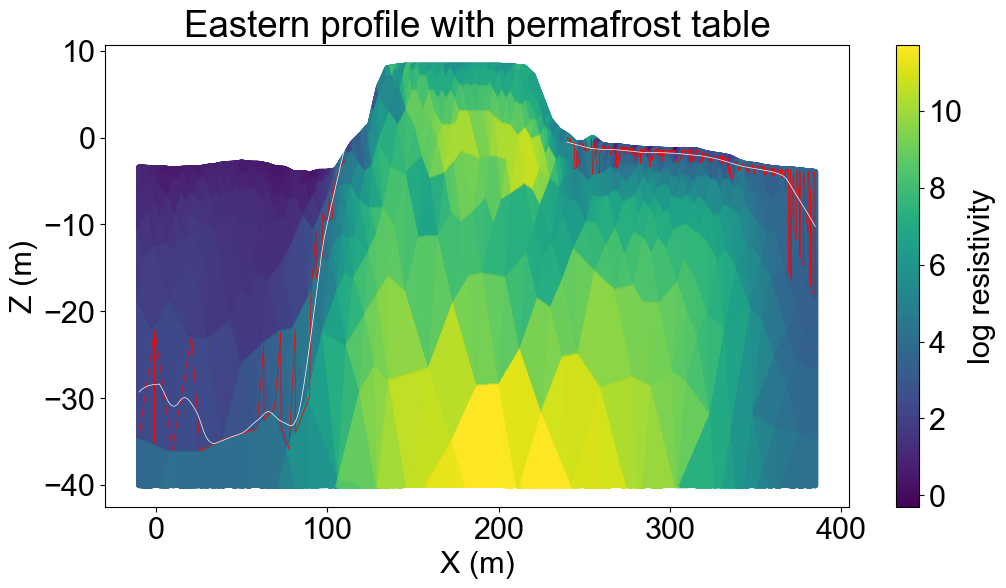

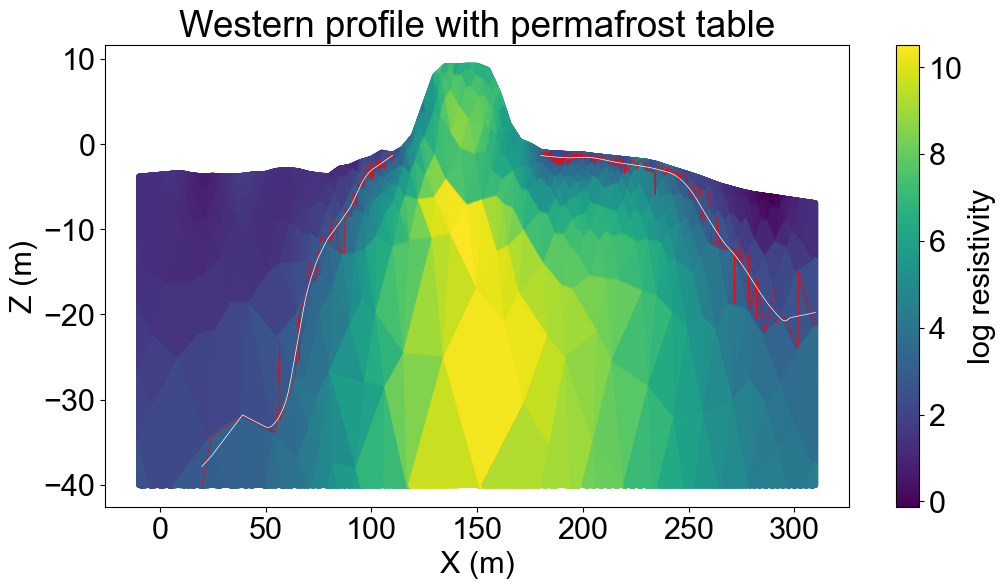

In [84]:
plot_and_save_permafrost_data(out_east, 110, 240, east_top_permafrost_depths, 0.2, dir+ 'pygimli/', 'Eastern')
plot_and_save_permafrost_data(out_west, 110, 180, west_top_permafrost_depths, 0.2, output_dir=dir+ 'pygimli/', name='Western')

Combined Resistivity:
Bin edges: [1.06691839e+02 1.46443824e+04 2.91820730e+04 4.37197636e+04
 5.82574541e+04 7.27951447e+04 8.73328353e+04 1.01870526e+05
 1.16408216e+05 1.30945907e+05 1.45483598e+05]
Counts: [1979  312    0  319    0    2    0    0    0   38]


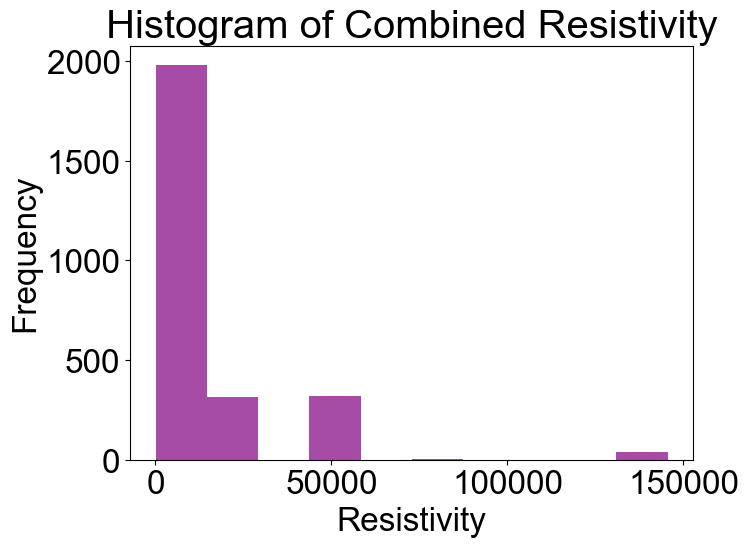

In [378]:
import numpy as np
import matplotlib.pyplot as plt

resistivity_interp1 = np.load(dir + 'pygimli/Eastern_resistivity_section1.npy')
resistivity_interp2 = np.load(dir + 'pygimli/Eastern_resistivity_section2.npy')

# Combine resistivity values from both sections
combined_resistivity = np.concatenate((resistivity_interp1, resistivity_interp2))

# Define number of bins
num_bins = 10

# Calculate histogram data for the combined resistivity
counts, bin_edges = np.histogram(combined_resistivity, bins=num_bins)
print("Combined Resistivity:")
print("Bin edges:", bin_edges)
print("Counts:", counts)

# Plot histogram for the combined resistivity
plt.figure(figsize=(8, 6))
plt.hist(combined_resistivity, bins=num_bins, color='purple', alpha=0.7)
plt.title('Histogram of Combined Resistivity')
plt.xlabel('Resistivity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Optionally save the bin edges and counts
#np.save(dir + 'pygimli/Eastern_combined_resistivity_bins.npy', bin_edges)
#np.save(dir + 'pygimli/Eastern_combined_resistivity_counts.npy', counts)


Combined Resistivity:
Bin edges: [2.04120631e+01 4.29874105e+03 8.57707004e+03 1.28553990e+04
 1.71337280e+04 2.14120570e+04 2.56903860e+04 2.99687150e+04
 3.42470440e+04 3.85253729e+04 4.28037019e+04 4.70820309e+04
 5.13603599e+04 5.56386889e+04 5.99170179e+04 6.41953469e+04
 6.84736758e+04 7.27520048e+04 7.70303338e+04 8.13086628e+04
 8.55869918e+04 8.98653208e+04 9.41436498e+04 9.84219787e+04
 1.02700308e+05 1.06978637e+05 1.11256966e+05 1.15535295e+05
 1.19813624e+05 1.24091953e+05 1.28370282e+05 1.32648611e+05
 1.36926940e+05 1.41205269e+05 1.45483598e+05]
Counts: [3789  183   63    0   26    0  286    0    0    0  140  179    0    0
    0    0    0    0    0    0    2    0    0    0    0    0    0    0
    0    0    0    0    0   38]


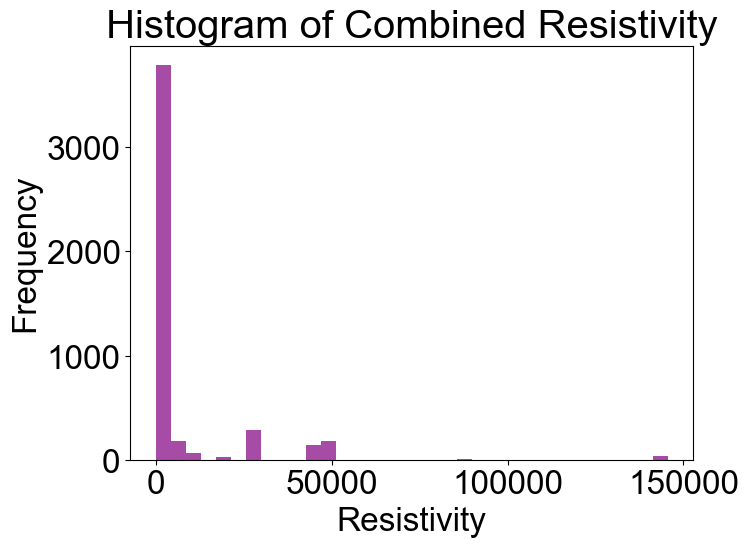

In [379]:
import numpy as np
import matplotlib.pyplot as plt

resistivity_interp1 = np.load(dir + 'pygimli/Western_resistivity_section1.npy')
resistivity_interp2 = np.load(dir + 'pygimli/Western_resistivity_section2.npy')
resistivity_interp3 = np.load(dir + 'pygimli/Eastern_resistivity_section1.npy')
resistivity_interp4 = np.load(dir + 'pygimli/Eastern_resistivity_section2.npy')

# Combine resistivity values from both sections
combined_resistivity = np.concatenate((resistivity_interp1, resistivity_interp2, resistivity_interp3, resistivity_interp4))

# Define number of bins
n = len(combined_resistivity)  # Number of data points
num_bins = int(np.ceil(2 * n**(1/3)))  # Apply Rice Rule formula

# Calculate histogram data for the combined resistivity
counts, bin_edges = np.histogram(combined_resistivity, bins=num_bins)
print("Combined Resistivity:")
print("Bin edges:", bin_edges)
print("Counts:", counts)

# Plot histogram for the combined resistivity
plt.figure(figsize=(8, 6))
plt.hist(combined_resistivity, bins=num_bins, color='purple', alpha=0.7)
plt.title('Histogram of Combined Resistivity')
plt.xlabel('Resistivity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Optionally save the bin edges and counts
#np.save(dir + 'pygimli/Eastern_combined_resistivity_bins.npy', bin_edges)
#np.save(dir + 'pygimli/Eastern_combined_resistivity_counts.npy', counts)


Bin Range (Ohm-m) | Count
-----------------------------------
1 - 10 | 0
10 - 100 | 686
100 - 1000 | 2385
1000 - 10000 | 949
10000 - 100000 | 648


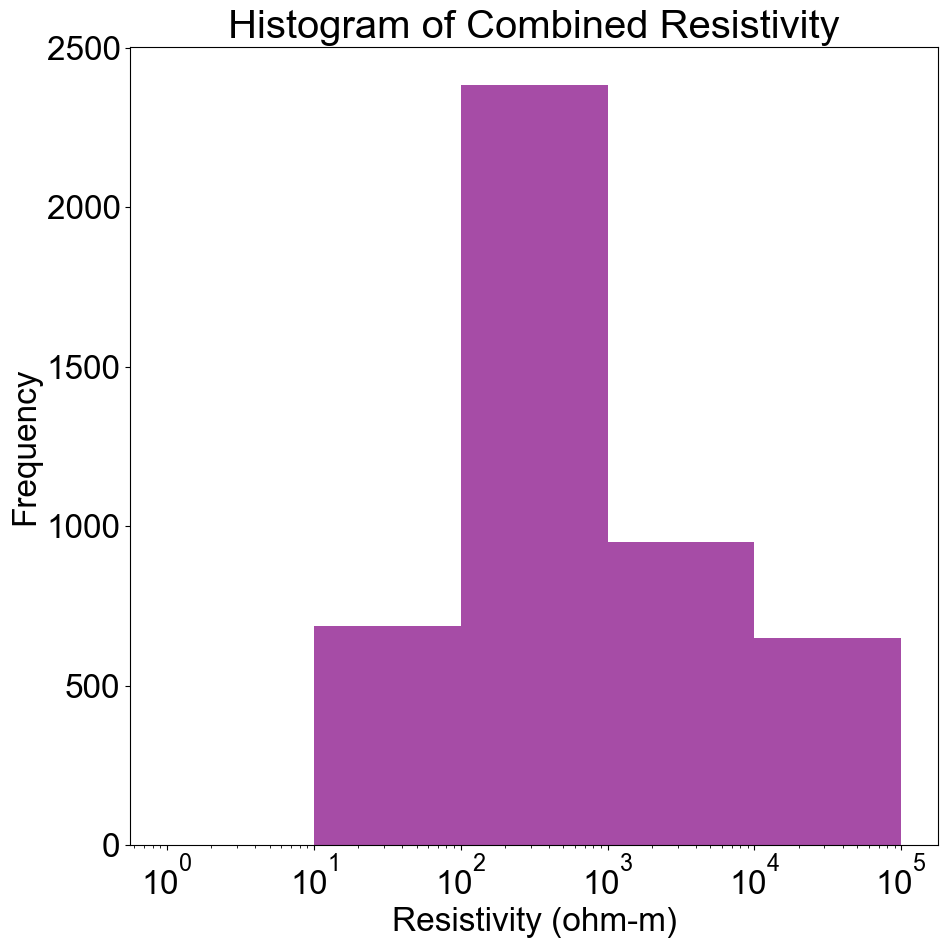

In [380]:
import numpy as np
import matplotlib.pyplot as plt

# Combine resistivity values from all sections
combined_resistivity = np.concatenate((resistivity_interp1, resistivity_interp2, resistivity_interp3, resistivity_interp4))

# Define the bins as powers of 10 (e.g., 1, 10, 100, 1000, 10000, etc.)
bin_edges = [1, 10, 100, 1000, 10000, 100000]  # Adjust as needed

# Calculate histogram data for the combined resistivity using these bins
counts, _ = np.histogram(combined_resistivity, bins=bin_edges)

# Print out the bin information
print("Bin Range (Ohm-m) | Count")
print("-----------------------------------")
for i in range(len(bin_edges)-1):
    print(f"{bin_edges[i]} - {bin_edges[i+1]} | {counts[i]}")

# Plot histogram with logarithmic x-axis
plt.figure(figsize=(10, 10))
plt.hist(combined_resistivity, bins=bin_edges, color='purple', alpha=0.7)
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.title('Histogram of Combined Resistivity')
plt.xlabel('Resistivity (ohm-m)')
plt.ylabel('Frequency')

# Customize tick marks for clarity
plt.tight_layout()
plt.show()




Dataset: Out East
-----------------------------------
1 - 10 | 204197
10 - 100 | 211728
100 - 1000 | 294162
1000 - 10000 | 461797
10000 - 100000 | 357149

Dataset: Out West
-----------------------------------
1 - 10 | 268136
10 - 100 | 278967
100 - 1000 | 235356
1000 - 10000 | 276890
10000 - 100000 | 173539

Dataset: Out East P
-----------------------------------
1 - 10 | 0
10 - 100 | 0
100 - 1000 | 220671
1000 - 10000 | 691863
10000 - 100000 | 253752

Dataset: Out West P
-----------------------------------
1 - 10 | 0
10 - 100 | 441837
100 - 1000 | 409694
1000 - 10000 | 338602
10000 - 100000 | 14807



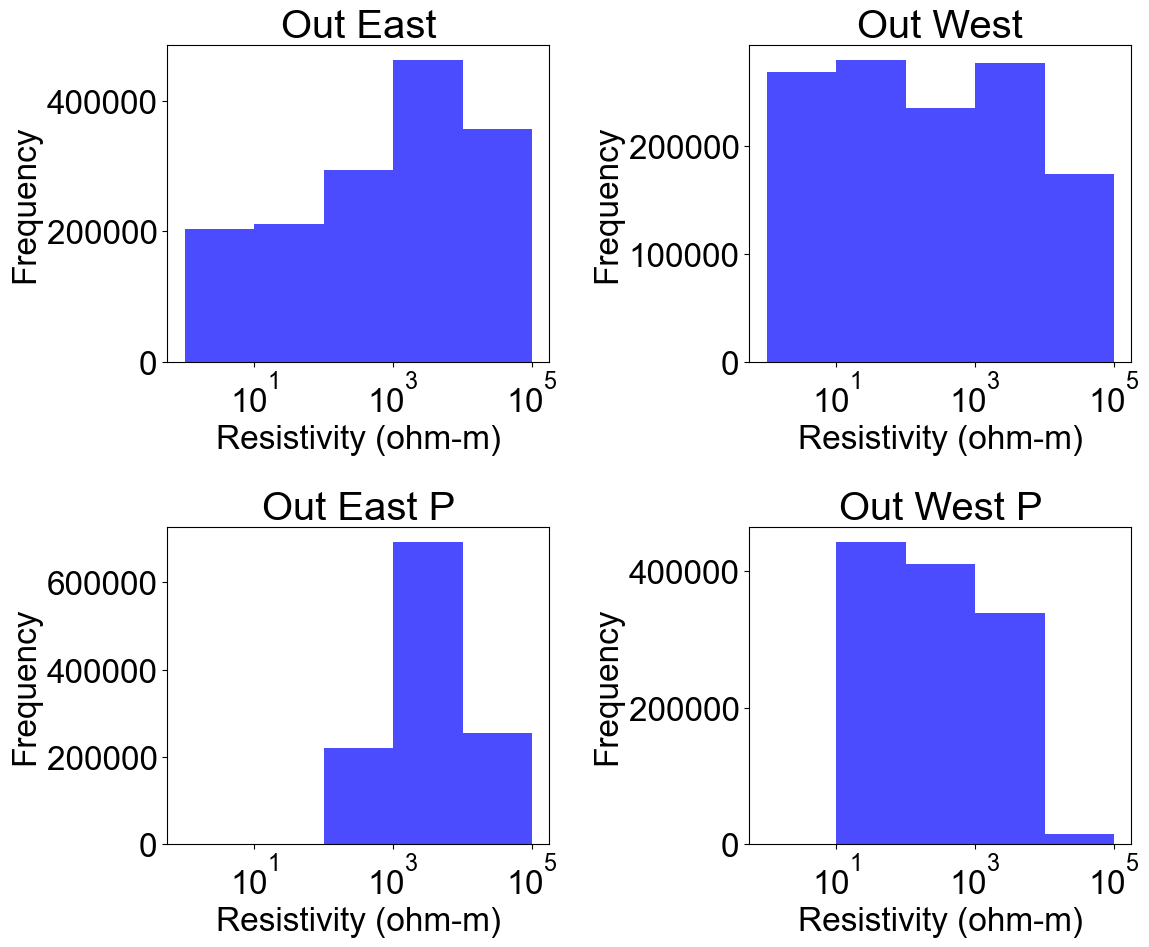

In [392]:
import matplotlib.pyplot as plt
import numpy as np

# Define the bins as powers of 10 (adjust based on your data range)
bin_edges = [1, 10, 100, 1000, 10000, 100000]

# Define datasets (replace with your actual data arrays)
datasets = [out_east[:, 2], out_west[:, 2], out_east_p[:, 2], out_west_p[:, 2]]
titles = ["Out East", "Out West", "Out East P", "Out West P"]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axes.flatten()):
    # Calculate histogram data
    counts, _ = np.histogram(datasets[i], bins=bin_edges)
    
    # Print bin count information
    print(f"Dataset: {titles[i]}")
    print("-----------------------------------")
    for j in range(len(bin_edges) - 1):
        print(f"{bin_edges[j]} - {bin_edges[j + 1]} | {counts[j]}")
    print()
    
    # Plot histogram for each dataset
    ax.hist(datasets[i], bins=bin_edges, color='blue', alpha=0.7)
    ax.set_xscale('log')  # Logarithmic scale for resistivity
    ax.set_title(titles[i])
    ax.set_xlabel('Resistivity (ohm-m)')
    ax.set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()



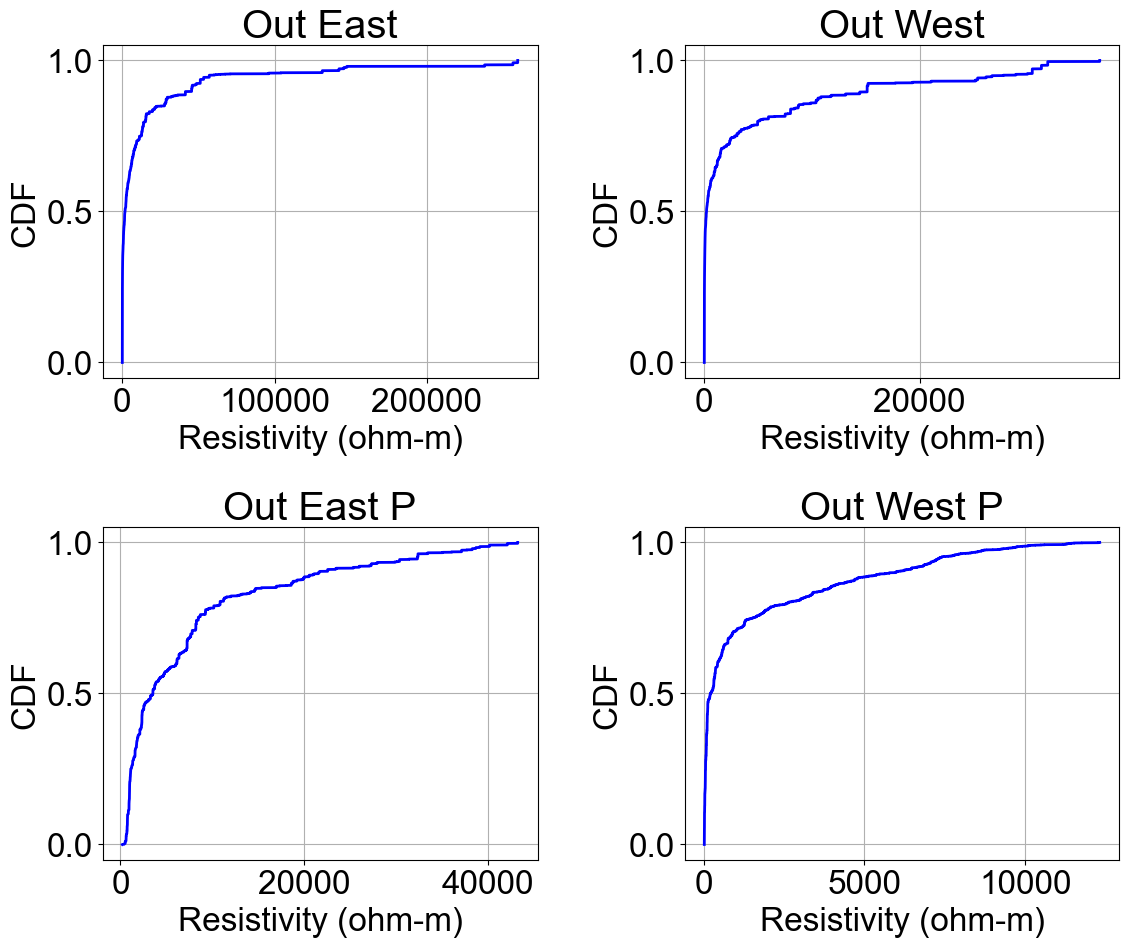

In [393]:
import numpy as np
import matplotlib.pyplot as plt

# Define datasets (replace with your actual data arrays)
datasets = [out_east[:, 2], out_west[:, 2], out_east_p[:, 2], out_west_p[:, 2]]
titles = ["Out East", "Out West", "Out East P", "Out West P"]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axes.flatten()):
    # Calculate CDF
    data = datasets[i]
    sorted_data = np.sort(data)  # Sort the data in ascending order
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)  # Calculate the CDF

    # Plot the CDF
    ax.plot(sorted_data, cdf, color='blue', lw=2)
    ax.set_title(titles[i])
    ax.set_xlabel('Resistivity (ohm-m)')
    ax.set_ylabel('CDF')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


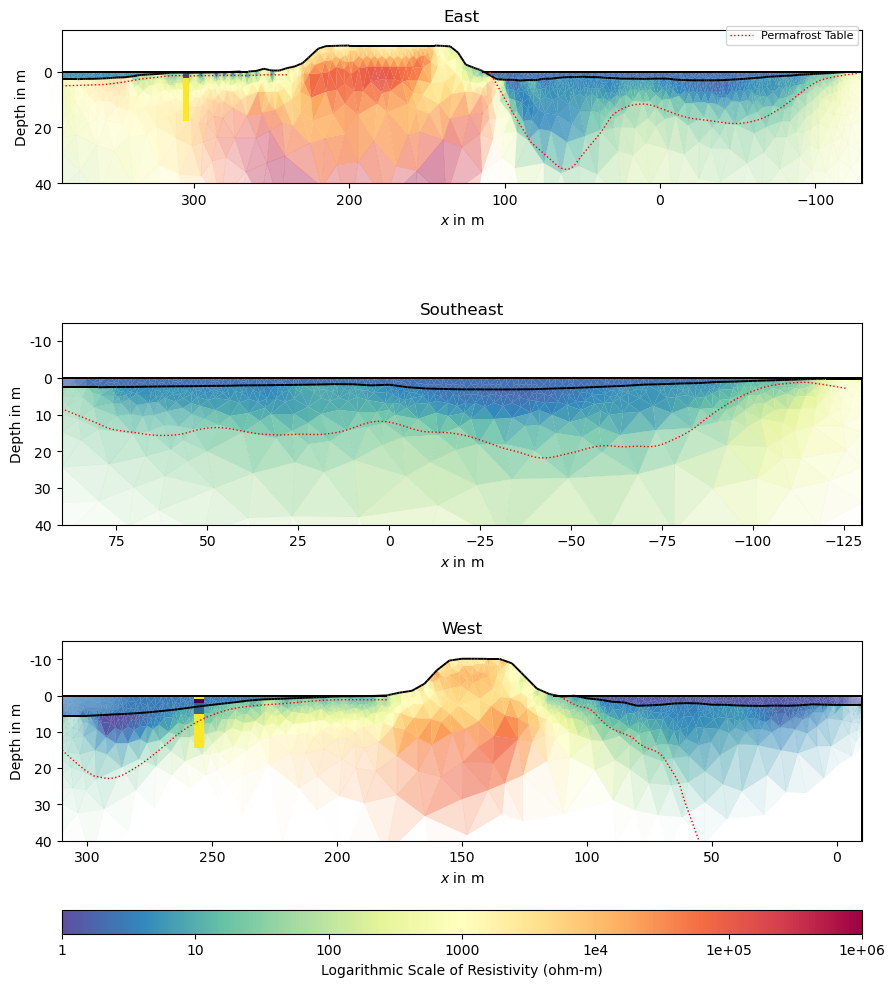

In [14]:
from matplotlib.ticker import LogLocator, LogFormatter

borehole4 = pd.read_csv(dir + "pygimli/borehole4.csv")
borehole2 = pd.read_csv(dir + "pygimli/borehole2.csv")

AL = np.loadtxt(dir + "pygimli/AL_eastern.txt")

e_permafrost_table1 = np.load(dir+ 'pygimli/eastern_newrhoa_perm_table1.npy')
e_permafrost_table_smooth1 = np.load(dir+ 'pygimli/eastern_newrhoa_perm_table_smooth1.npy')
e_permafrost_table_x1 = np.load(dir+ 'pygimli/eastern_newrhoa_perm_table_x1.npy')

e_permafrost_table2 = np.load(dir+ 'pygimli/eastern_newrhoa_perm_table2.npy')
e_permafrost_table_smooth2 = np.load(dir+ 'pygimli/eastern_newrhoa_perm_table_smooth2.npy')
e_permafrost_table_x2 = np.load(dir+ 'pygimli/eastern_newrhoa_perm_table_x2.npy')

s_permafrost_table = np.load(dir+ 'pygimli/southeast_perm_table.npy')
s_permafrost_table_smooth = np.load(dir+ 'pygimli/southeast_perm_table_smooth.npy')
s_permafrost_table_x = np.load(dir+ 'pygimli/southeast_perm_table_x.npy')

w_permafrost_table1 = np.load(dir+ 'pygimli/western_perm_table1.npy')
w_permafrost_table_smooth1 = np.load(dir+ 'pygimli/western_perm_table_smooth1.npy')
w_permafrost_table_x1 = np.load(dir+ 'pygimli/western_perm_table_x1.npy')

w_permafrost_table2 = np.load(dir+ 'pygimli/western_perm_table2.npy')
w_permafrost_table_smooth2 = np.load(dir+ 'pygimli/western_perm_table_smooth2.npy')
w_permafrost_table_x2 = np.load(dir+ 'pygimli/western_perm_table_x2.npy')

x_e = borehole4['x']
z_e = borehole4['z']
r_e = borehole4['r']

x_w = borehole2['x']
z_w = borehole2['z']
r_w = borehole2['r']

x_AL = AL[0]
z_AL = AL[1]


fig, ax = plt.subplots(3, 1, figsize=(10, 12))  
#fig, ax = plt.subplots(1, 2, figsize=(10, 10))

pg.show(mesh_eastern, res_eastern, logScale=True, cMap="Spectral_r", ax=ax[0], colorBar=False, cMin=1, cMax=100000, coverage=cov_eastern)
pg.show(mesh_southeast, res_southeast, logScale=True, cMap="Spectral_r", ax=ax[1], colorBar=False, cMin=1, cMax=100000, coverage=cov_southeast)
pg.show(mesh_western, res_western, logScale=True, cMap="Spectral_r", ax=ax[2], colorBar=False, cMin=1, cMax=100000, coverage=cov_western)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.2) 


cax = fig.add_axes([0.1, 0.1, 0.8, 0.02])  

colorbar = pg.viewer.mpl.createColorBarOnly(ax=cax, cMin=1, cMax=1000000, logScale=True, cMap="Spectral_r")

cax.xaxis.set_major_locator(LogLocator(base=10.0))
cax.xaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))
cax.set_xlabel('Logarithmic Scale of Resistivity (ohm-m)', fontsize=10)

ax[1].set_title('Southeast')
ax[0].set_title('East')
ax[2].set_title('West')

ax[1].set_ylim(-40, 15)
ax[0].set_ylim(-40, 15)
ax[2].set_ylim(-40, 15)

ax[0].invert_xaxis()
ax[1].invert_xaxis()
ax[2].invert_xaxis()

ax[0].set_aspect(1.8)
ax[1].set_aspect(1.01)
ax[2].set_aspect(1.45)

zz_e = np.abs(z_e)
iz_e = np.argsort(z_e)
dz_e = np.diff(zz_e[iz_e])
thk_e = np.hstack([dz_e, dz_e[-1]])
ztop_e = -zz_e[iz_e[0]]-dz_e[0]/2
colkw_e = dict(x=x_e[0], val=r_e[iz_e], thk=thk_e, width=4, ztopo=ztop_e)
draw1DColumn(ax[0], **colkw_e)

zz_w = np.abs(z_w)
iz_w = np.argsort(z_w)
dz_w = np.diff(zz_w[iz_w])
thk_w = np.hstack([dz_w, dz_w[-1]])
ztop_w = -zz_w[iz_w[0]]-dz_w[0]/2
colkw_w = dict(x=x_w[0], val=r_w[iz_w], thk=thk_w, width=4, ztopo=ztop_w)
draw1DColumn(ax[2], **colkw_w)

line1, = ax[0].plot(e_permafrost_table_x1, e_permafrost_table_smooth1, ":", linewidth=1, color='red', label='Permafrost Table')
line2, = ax[0].plot(e_permafrost_table_x2, e_permafrost_table_smooth2, ":", linewidth=1, color='red')
line3, = ax[1].plot(s_permafrost_table_x, s_permafrost_table_smooth, ":", linewidth=1, color='red')
line4, = ax[2].plot(w_permafrost_table_x1, w_permafrost_table_smooth1, ":", linewidth=1, color='red')
line5, = ax[2].plot(w_permafrost_table_x2, w_permafrost_table_smooth2, ":", linewidth=1, color='red')

#line1, = ax[0].plot(e_permafrost_table_x, e_permafrost_table, ":", linewidth=1, color='red', label='Permafrost Table')
#line2, = ax[1].plot(s_permafrost_table_x, s_permafrost_table, ":", linewidth=1, color='red')
#line2, = ax[2].plot(w_permafrost_table_x, w_permafrost_table, ":", linewidth=1, color='red')
#ax[0].plot(x_AL, z_AL, 'g_', linewidth=0.1)

ax[0].legend(loc=(0.83, 0.9), fontsize=8)

plt.show()



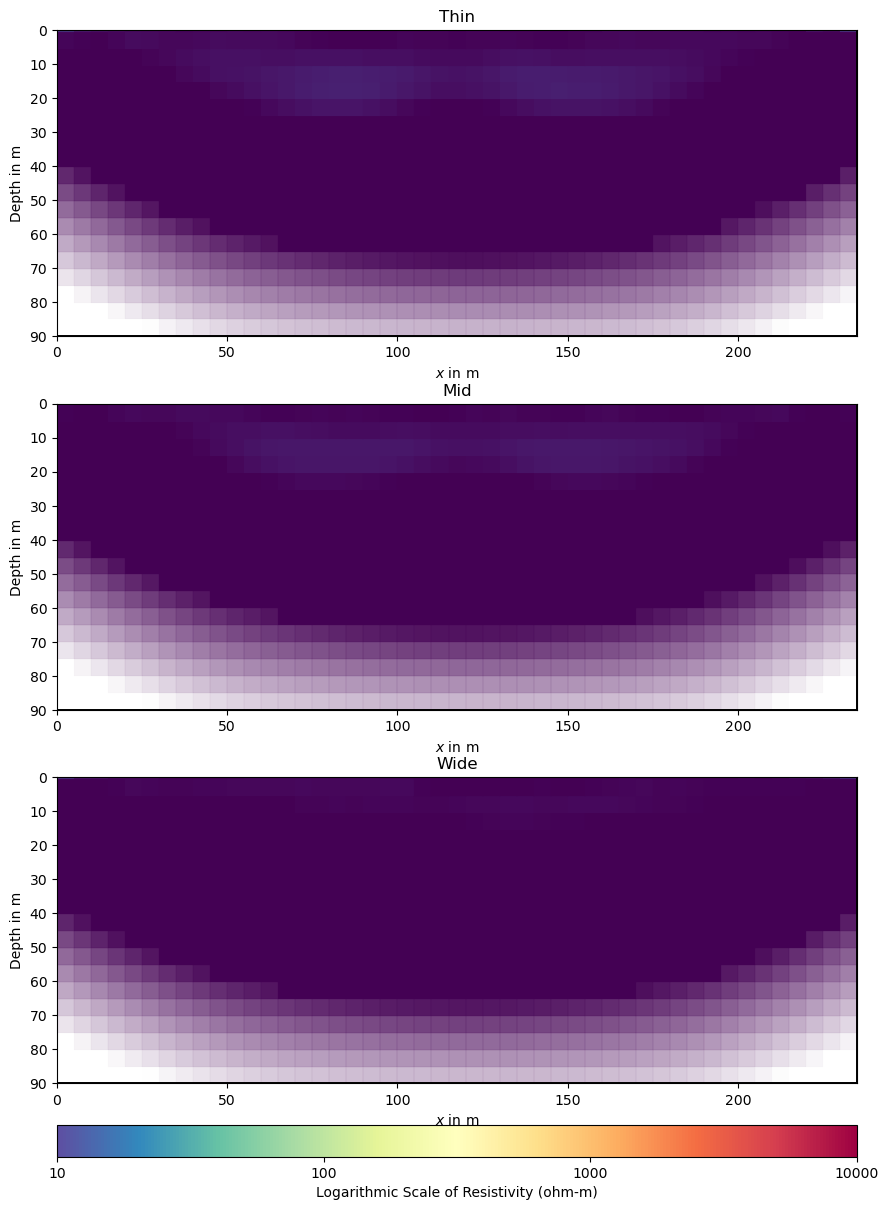

In [62]:
from matplotlib.ticker import LogLocator, LogFormatter



fig, ax = plt.subplots(3, 1, figsize=(10, 16))  
#fig, ax = plt.subplots(1, 2, figsize=(10, 10))

pg.show(mesh_thin, res_thin, logScale=True, cMap="viridis_r", ax=ax[0], colorBar=False, cMin=100, cMax=1000, coverage=cov_thin, sharex=True)
pg.show(mesh_mid, res_mid, logScale=True, cMap="viridis_r", ax=ax[1], colorBar=False, cMin=100, cMax=1000, coverage=cov_mid, sharex=True)
pg.show(mesh_wide, res_wide, logScale=True, cMap="viridis_r", ax=ax[2], colorBar=False, cMin=100, cMax=1000, coverage=cov_wide, sharex=True)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.5) 


cax = fig.add_axes([0.1, 0.15, 0.8, 0.02])  

colorbar = pg.viewer.mpl.createColorBarOnly(ax=cax, cMin=10, cMax=10000, logScale=True, cMap="Spectral_r")

cax.xaxis.set_major_locator(LogLocator(base=10.0))
cax.xaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))
cax.set_xlabel('Logarithmic Scale of Resistivity (ohm-m)', fontsize=10)

ax[0].set_title('Thin')
ax[1].set_title('Mid')
ax[2].set_title('Wide')




plt.show()



19/12/24 - 14:55:14 - pyGIMLi - INFO - could not read unified data format for ERT ... try res2dinv
19/12/24 - 14:55:15 - pyGIMLi - INFO - could not read unified data format for ERT ... try res2dinv
19/12/24 - 14:55:15 - pyGIMLi - INFO - Cache c:\Users\mealiy001\AppData\Local\anaconda3\envs\pgcore\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (1.6s x 22): C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\7107516685755831498
19/12/24 - 14:55:15 - pyGIMLi - INFO - Cache c:\Users\mealiy001\AppData\Local\anaconda3\envs\pgcore\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 22): C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\5525447937356186559
19/12/24 - 14:55:15 - pyGIMLi - INFO - Cache c:\Users\mealiy001\AppData\Local\anaconda3\envs\pgcore\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (4.8s x 22): C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\2338284238765559255
19/12/24 - 14:55:15 - pyG

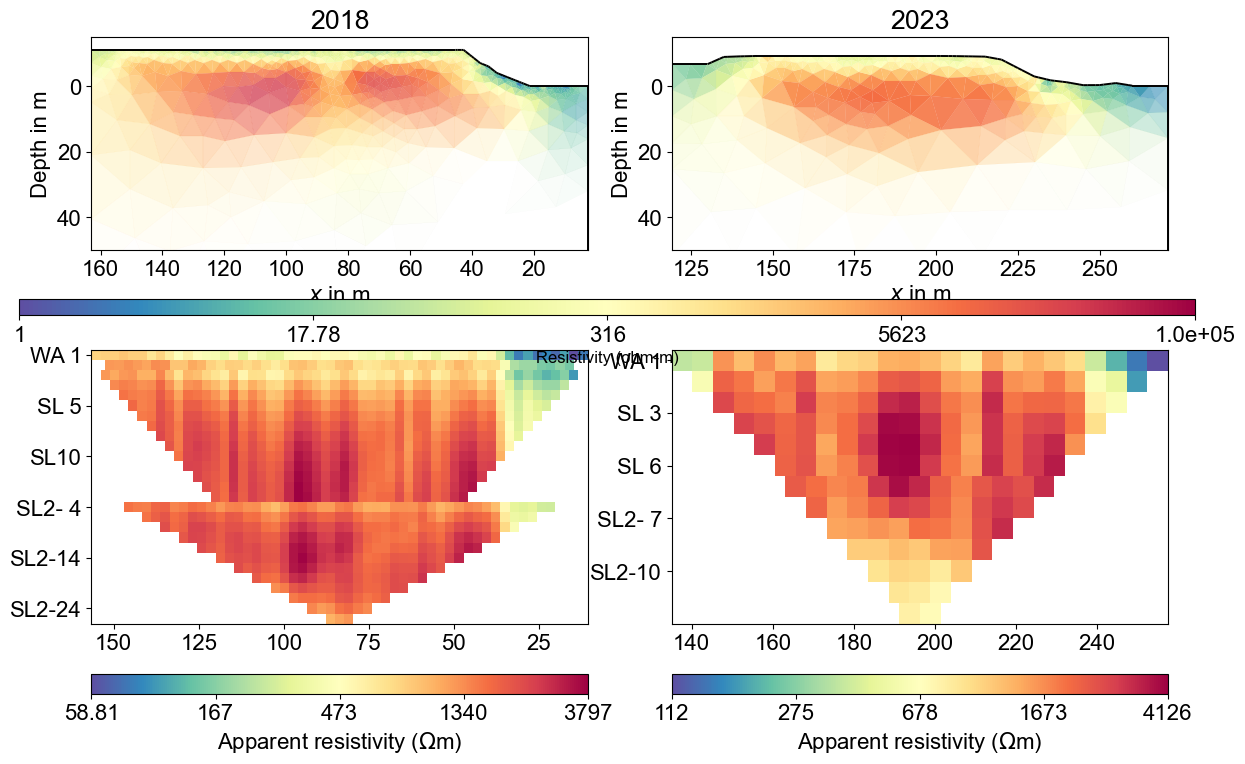

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pygimli as pg  # assuming pg is an alias for PyGIMLi
from matplotlib.ticker import MultipleLocator

data_e = ert.load(dir+"res2dinv_inputs/transects_split_in_three/amphibious_ERT_eastern_transect_gps_center.dat")
data_a = ert.load(dir+"processing/arenson/arenson_updated.dat")

#data.setSensorPositions(pg.meshtools.interpolateAlongCurve(data.additionalPoints(), pg.x(data)))
data_e['k'] = ert.createGeometricFactors(data_e, numerical=True)
mgr = ert.ERTManager(sr=False)
k0 = ert.createGeometricFactors(data_e)
data_e['err'] = ert.estimateError(data_e, relativeError=0.03, absoluteUError=5e-5)

data_a['k'] = ert.createGeometricFactors(data_a, numerical=True)
mgr = ert.ERTManager(sr=False)
k0 = ert.createGeometricFactors(data_a)
data_a['err'] = ert.estimateError(data_a, relativeError=0.03, absoluteUError=5e-5)

# Define common normalization and colormap for linear scale
cmin = 10
cmax = 100000
cmap = "Spectral_r"

# Create a 1x2 grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Plot on the subplots with the common normalization and colormap
pg.show(mesh_arenson, res_arenson, cMap=cmap, ax=ax[0][0], colorBar=False, cMin=cmin, cMax=cmax,logScale=True, sharey = True, coverage=cov_arenson)
pg.show(mesh_eastern_center, res_eastern_center, cMap=cmap, ax=ax[0][1], colorBar=False, cMin=cmin, cMax=cmax, logScale=True, sharey = True, coverage=cov_eastern_center)
ert.showERTData(data_a, ax = ax[1][0], colorBar=True, sharey = True)
ert.showERTData(data_e, ax = ax[1][1], colorBar=True, sharey = True)

cax1 = fig.add_axes([0.01, 0.54, 0.98, 0.02])  
colorbar1 = pg.viewer.mpl.createColorBarOnly(ax=cax1, cMin=1, cMax=100000, logScale=True, cMap="Spectral_r")


ax[0][1].set_title('2023')
ax[0][0].set_title('2018')

ax[0][0].set_ylim(-50, 15)
ax[0][1].set_ylim(-50, 15)
#ax[0].set_xlim(120, 275)
#ax[1].set_xlim(0, 155)
ax[0][0].invert_xaxis()
ax[1][0].invert_xaxis()
# Set aspect ratio to equal for both subplots
#ax[0].set_aspect(2)
ax[0][0].set_aspect(1.06)

ax[0][0].xaxis.set_major_locator(MultipleLocator(20))
ax[0][0].xaxis.set_major_locator(MultipleLocator(20))

#tick_positions1 = [160, 140, 120, 100, 80, 60, 40, 20]
#tick_labels1 = ['0', '20', '40', '60', '80', '100', '120', '140']
#ax[1].set_xticks(tick_positions1)
#ax[1].set_xticklabels(tick_labels1)


#tick_positions1 = [160, 140, 120, 100, 80, 60, 40, 20]
#tick_labels1 = ['0', '20', '40', '60', '80', '100', '120', '140']
#ax[1].set_xticks(tick_positions1)
#ax[1].set_xticklabels(tick_labels1)

#cax.xaxis.set_major_locator(LogLocator(base=10.0))
#cax.xaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))
cax1.set_xlabel('Resistivity (ohm-m)', fontsize=12)
#plt.tight_layout()  # Adjust layout to fit the colorbar
#plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9) 
plt.show()



19/12/24 - 14:55:20 - pyGIMLi - INFO - could not read unified data format for ERT ... try res2dinv


19/12/24 - 14:55:20 - pyGIMLi - INFO - could not read unified data format for ERT ... try res2dinv
19/12/24 - 14:55:20 - pyGIMLi - INFO - Cache c:\Users\mealiy001\AppData\Local\anaconda3\envs\pgcore\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (1.6s x 23): C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\7107516685755831498
19/12/24 - 14:55:20 - pyGIMLi - INFO - Cache c:\Users\mealiy001\AppData\Local\anaconda3\envs\pgcore\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 23): C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\5525447937356186559
19/12/24 - 14:55:20 - pyGIMLi - INFO - Cache c:\Users\mealiy001\AppData\Local\anaconda3\envs\pgcore\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (4.8s x 23): C:\Users\mealiy001\AppData\Roaming\pygimli\Cache\2338284238765559255
19/12/24 - 14:55:20 - pyGIMLi - INFO - Cache c:\Users\mealiy001\AppData\Local\anaconda3\envs\pgcore\Lib\site-packages\pygiml

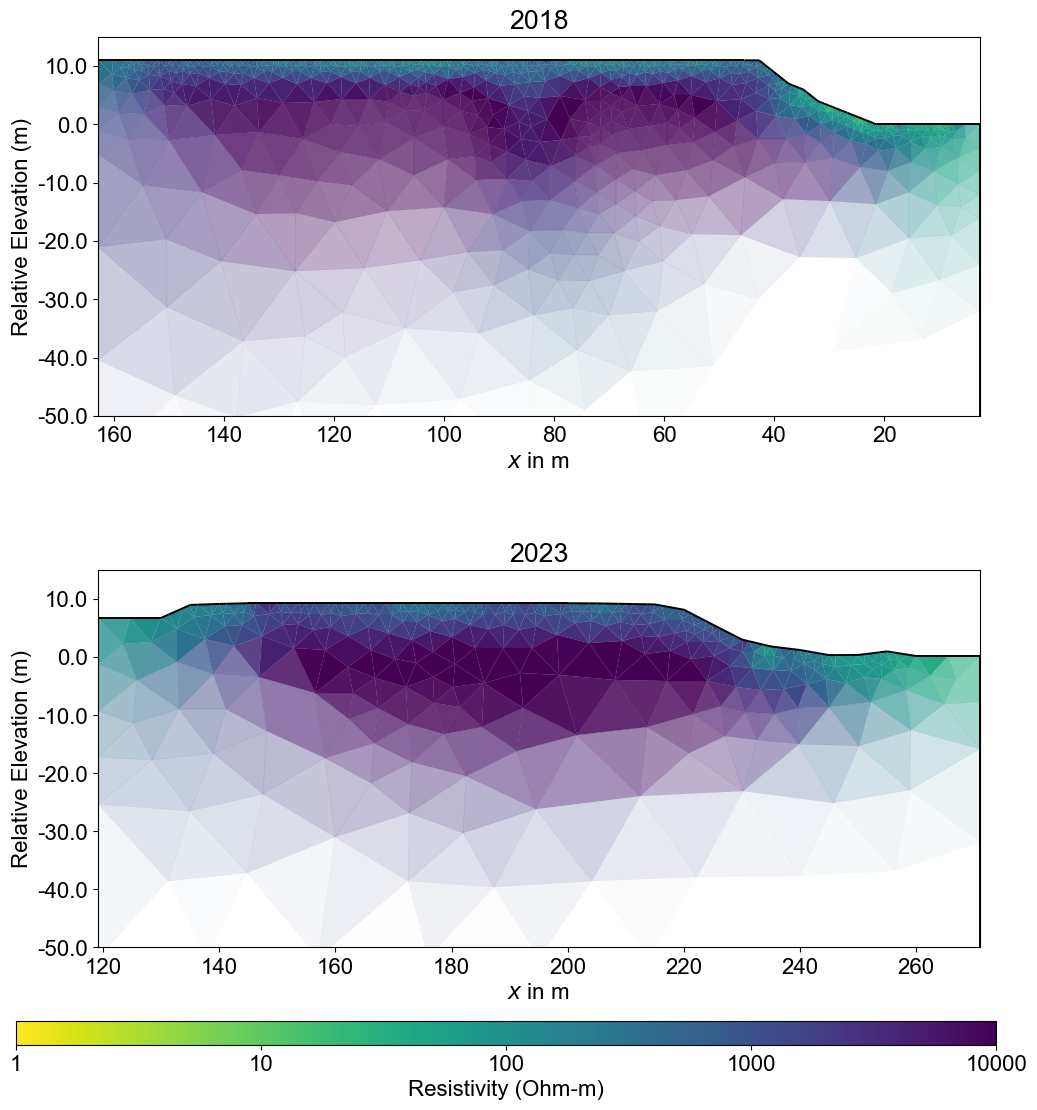

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pygimli as pg  # assuming pg is an alias for PyGIMLi
from matplotlib.ticker import MultipleLocator

plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'Arial'
plt.style.use('seaborn-v0_8-colorblind')

data_e = ert.load(dir+"res2dinv_inputs/transects_split_in_three/amphibious_ERT_eastern_transect_gps_center.dat")
data_a = ert.load(dir+"processing/arenson/arenson_updated.dat")

#data.setSensorPositions(pg.meshtools.interpolateAlongCurve(data.additionalPoints(), pg.x(data)))
data_e['k'] = ert.createGeometricFactors(data_e, numerical=True)
mgr = ert.ERTManager(sr=False)
k0 = ert.createGeometricFactors(data_e)
data_e['err'] = ert.estimateError(data_e, relativeError=0.03, absoluteUError=5e-5)

data_a['k'] = ert.createGeometricFactors(data_a, numerical=True)
mgr = ert.ERTManager(sr=False)
k0 = ert.createGeometricFactors(data_a)
data_a['err'] = ert.estimateError(data_a, relativeError=0.03, absoluteUError=5e-5)

# Define common normalization and colormap for linear scale
cmin = 1
cmax = 10000
cmap = "viridis_r"

# Create a 1x2 grid of subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Plot on the subplots with the common normalization and colormap
pg.show(mesh_arenson, res_arenson, cMap=cmap, ax=ax[0], colorBar=False, cMin=cmin, cMax=cmax,logScale=True, sharey = True, coverage=cov_arenson)
pg.show(mesh_eastern_center, res_eastern_center, cMap=cmap, ax=ax[1], colorBar=False, cMin=cmin, cMax=cmax, logScale=True, sharey = True, coverage=cov_eastern_center)


cax = fig.add_axes([0.01, 0.04, 0.98, 0.02])  
colorbar1 = pg.viewer.mpl.createColorBarOnly(ax=cax, cMin=cmin, cMax=cmax, logScale=True, cMap="viridis_r")


ax[1].set_title('2023')
ax[0].set_title('2018')

ax[0].set_ylim(-50, 15)
ax[1].set_ylim(-50, 15)

ax[0].invert_xaxis()
#ax[1].invert_xaxis()

current_ticks = ax[0].get_yticks()
relative_ticks = current_ticks   # Assuming 17 is the minimum elevation

# Set the new tick labels to show relative elevation

ax[0].set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])
ax[0].set_ylabel("Relative Elevation (m)")
ax[1].set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])
ax[1].set_ylabel("Relative Elevation (m)")

ax[0].set_aspect(1.06)

cax.xaxis.set_major_locator(LogLocator(base=10.0))
cax.xaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))
cax.set_xlabel('Resistivity (Ohm-m)')

plt.savefig(dir + 'paper/figures/arenson_figure.png', dpi=300, bbox_inches='tight')

plt.show()


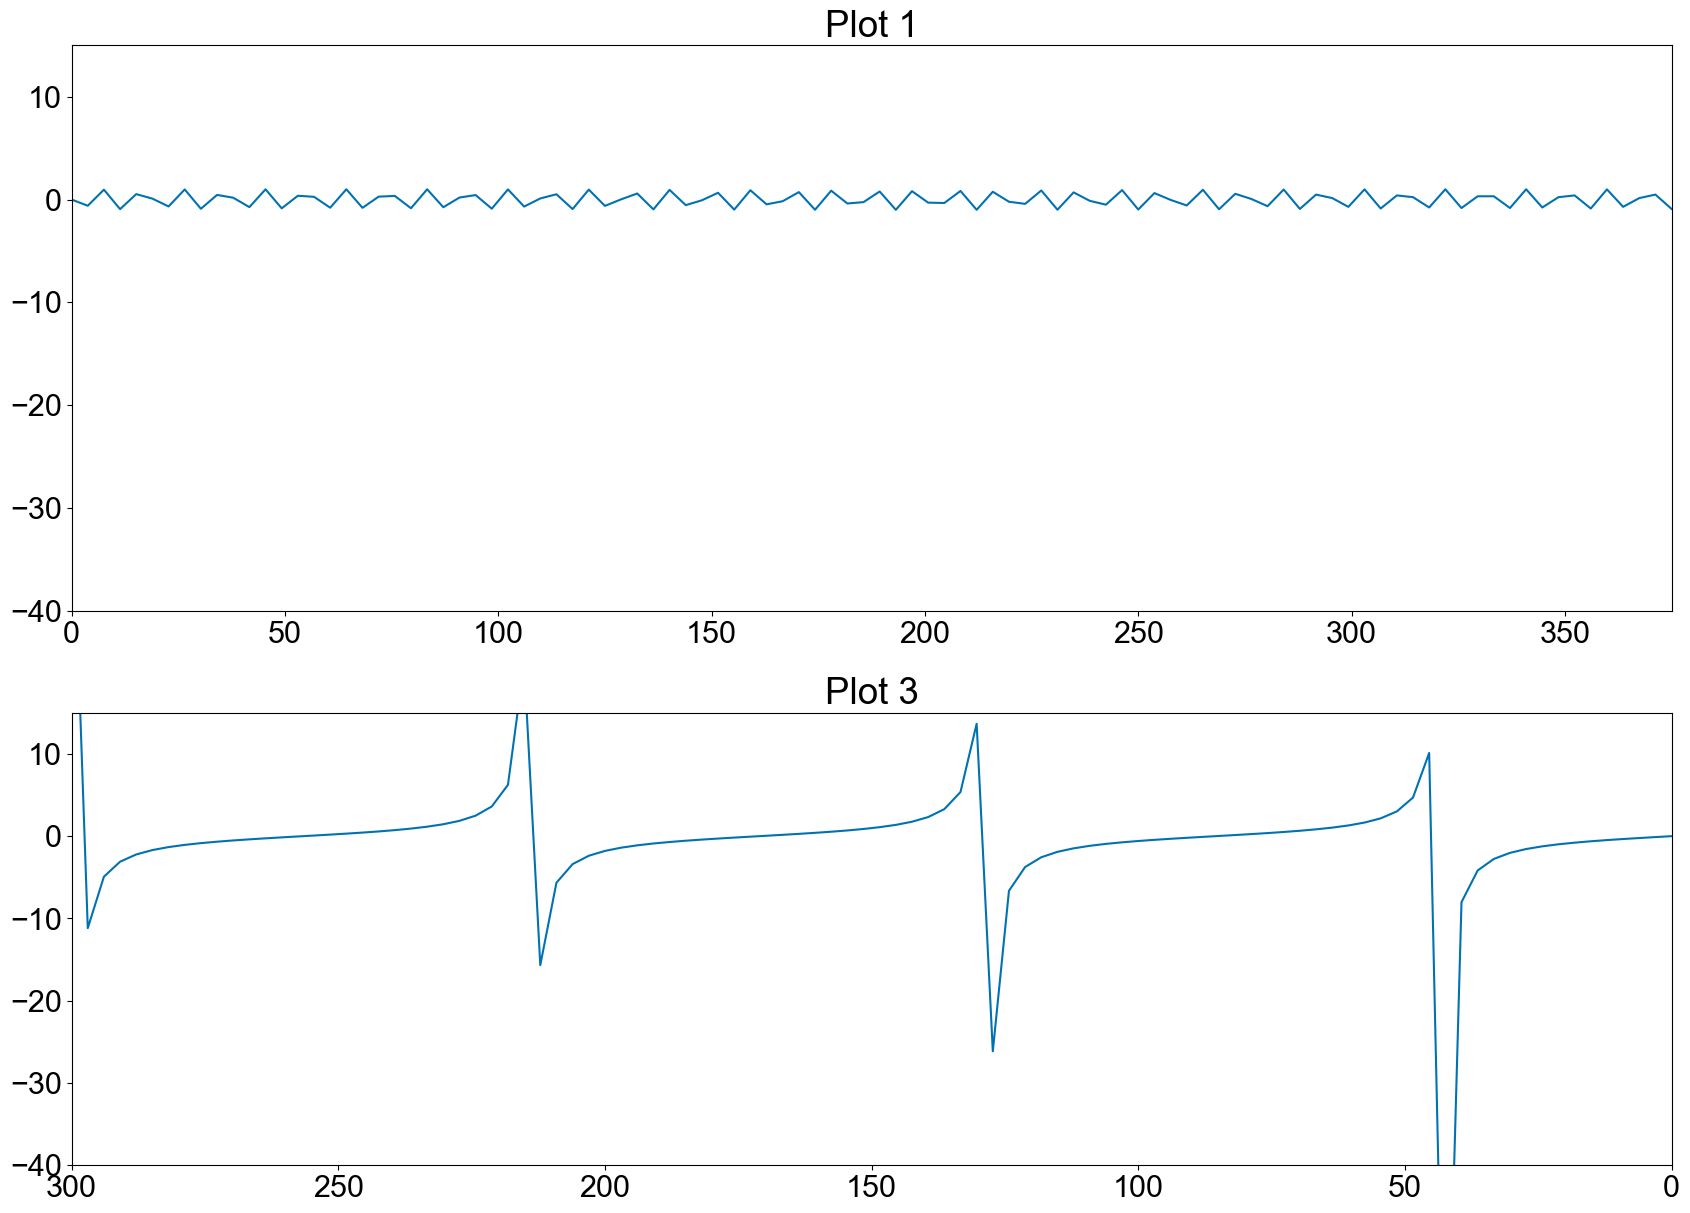

In [85]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Example data for plotting
x1 = np.linspace(375, 0, 100)
y1 = np.sin(x1)

x3 = np.linspace(300, 0, 100)
y3 = np.tan(x3)

# Create a figure
fig = plt.figure(figsize=(40, 28))

# Define the GridSpec layout with specified ratios
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 0.8])

# Create the first subplot in the first row and first column
ax0 = fig.add_subplot(gs[0])
ax0.plot(x1, y1)
ax0.set_xlim(0, 375)
ax0.set_ylim(-40, 15)
ax0.set_title('Plot 1')


ax2 = fig.add_subplot(gs[1])
ax2.plot(x3, y3)
ax2.set_xlim(300, 0)
ax2.set_ylim(-40, 15)
ax2.set_title('Plot 3')

fig.subplots_adjust(left=0.3, right=0.7, bottom=0.3, top=0.7)

# Get the bounding boxes of the subplots
bbox0 = ax0.get_position()

bbox2 = ax2.get_position()

# Extract the coordinates from the bounding boxes
x0_0, y0_0, width_0, height_0 = bbox0.x0, bbox0.y0, bbox0.width, bbox0.height
x0_2, y0_2, width_2, height_2 = bbox2.x0, bbox2.y0, bbox2.width, bbox2.height


Values in val: [(0, -0.9, 'Ice'), (-0.9, -2.4, 'Unfrozen Matter'), (-2.4, -17.6, 'Ice Bonded Permafrost')]
Values in val: [(0, -0.9, 'Ice'), (-0.9, -2.1, 'Water'), (-2.1, -5.2, 'Unfrozen Matter'), (-5.2, -14.6, 'Ice Bonded Permafrost')]


C:\Users\mealiy001\AppData\Local\Temp\ipykernel_19496\2470440248.py:166: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])
C:\Users\mealiy001\AppData\Local\Temp\ipykernel_19496\2470440248.py:168: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])


Text(0.5, 358.2909722222222, 'Resistivity (Ohm-m)')

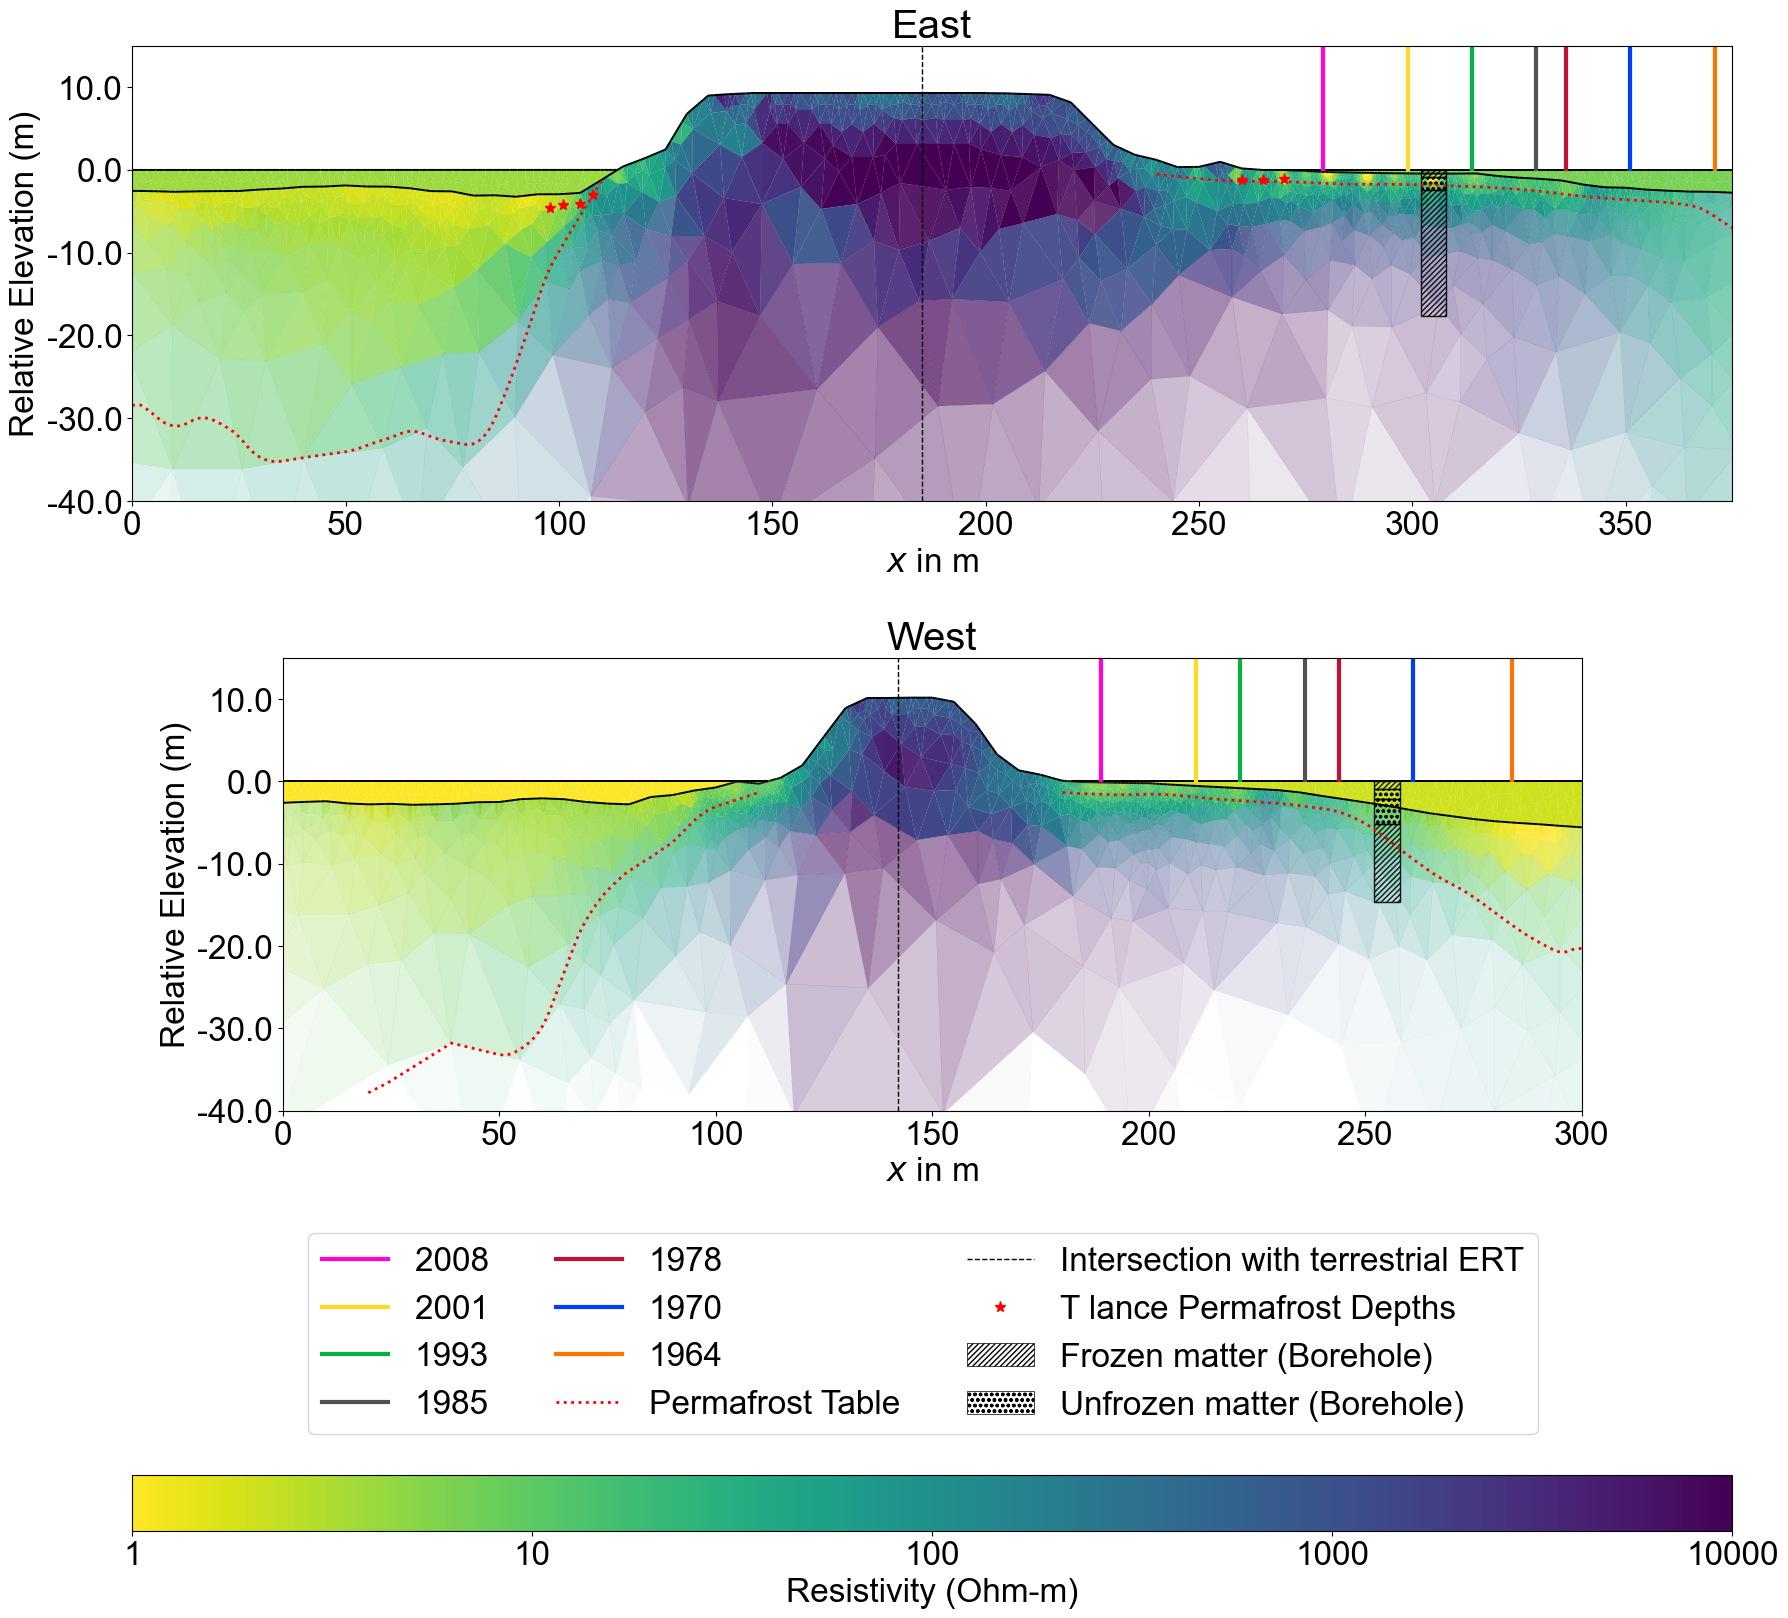

In [138]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize

east_shore_df = pd.read_csv(dir + "pygimli/shorelines_gimli_eastern.csv")
west_shore_df = pd.read_csv(dir + "pygimli/shorelines_gimli_western.csv")
eastern_topo = np.loadtxt(dir + "res2dinv_inputs/eastern_topo.txt")
interpolated_topography = interp1d(eastern_topo[:, 0], eastern_topo[:, 1], kind='linear', fill_value='extrapolate')
x = np.arange(0, 375 + 1, 1)
adjusted_topography = []

for x_val in x:
    y_val = interpolated_topography(x_val)
    adjusted_topography.append(y_val)
adjusted_topography       
plt.rcParams['font.size'] = 24
plt.rcParams['font.family'] = 'Arial'
plt.style.use('seaborn-v0_8-colorblind')
cMin=1
cMax=10000


# Define colors for the custom colormap
colors = ['#ff7300', '#003cff', '#be1332', '#515151', '#07b340', '#ffdd1f', '#ff00e1']  # Blue to green to yellow to red
cmap_name = 'custom_cmap'

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
custom_cmap= custom_cmap.reversed()

# If you need NumPy arrays
east_shore = east_shore_df.to_numpy()
west_shore = west_shore_df.to_numpy()

borehole4 = pd.read_csv(dir + "pygimli/borehole4.csv")
borehole2 = pd.read_csv(dir + "pygimli/borehole2.csv")

def draw1DColumn(ax, x, val, thk, hatch_patterns):
    print("Values in val:", val)
    bottom = 0
    for v, t in zip(val, thk):
        material_type = v[2]  
        if material_type not in hatch_patterns:
            print("Error: Hatch pattern not found for material:", v)
            continue
        hatch = hatch_patterns[material_type]
        ax.bar(x, t, bottom=bottom, width=6, edgecolor='black', alpha=0.9, facecolor='none', hatch=hatch, linewidth=1)
        bottom += t


borehole2_data = [(0, -0.9, 'Ice'), (-0.9, -2.1, 'Water'), (-2.1, -5.2, 'Unfrozen Matter'), (-5.2, -14.6, 'Ice Bonded Permafrost')]
borehole4_data = [(0, -0.9, 'Ice'), (-0.9, -2.4, 'Unfrozen Matter'), (-2.4, -17.6, 'Ice Bonded Permafrost')]

hatch_patterns = {'Ice': '//////', 'Water': 'ooo', 'Unfrozen Matter': 'ooo', 'Ice Bonded Permafrost': '//////'}

AL_e = np.loadtxt(dir + "pygimli/AL_eastern.txt")
AL_w = np.loadtxt(dir + "pygimli/AL_western.txt")

e_permafrost_table1 = np.load(dir+ 'pygimli/Eastern_newrhoa_perm_table1.npy')
e_permafrost_table_smooth1 = np.load(dir+ 'pygimli/Eastern_newrhoa_perm_table_smooth1.npy')
e_permafrost_table_x1 = np.load(dir+ 'pygimli/Eastern_newrhoa_perm_table_x1.npy')

e_permafrost_table2 = np.load(dir+ 'pygimli/Eastern_newrhoa_perm_table2.npy')
e_permafrost_table_smooth2 = np.load(dir+ 'pygimli/Eastern_newrhoa_perm_table_smooth2.npy')
e_permafrost_table_x2 = np.load(dir+ 'pygimli/Eastern_newrhoa_perm_table_x2.npy')

w_permafrost_table1 = np.load(dir+ 'pygimli/Western_newrhoa_perm_table1.npy')
w_permafrost_table_smooth1 = np.load(dir+ 'pygimli/Western_newrhoa_perm_table_smooth1.npy')
w_permafrost_table_x1 = np.load(dir+ 'pygimli/Western_newrhoa_perm_table_x1.npy')

w_permafrost_table2 = np.load(dir+ 'pygimli/Western_newrhoa_perm_table2.npy')
w_permafrost_table_smooth2 = np.load(dir+ 'pygimli/Western_newrhoa_perm_table_smooth2.npy')
w_permafrost_table_x2 = np.load(dir+ 'pygimli/Western_newrhoa_perm_table_x2.npy')

x_AL_e = AL_e[0]
z_AL_e = AL_e[1]
x_AL_w = AL_w[0]
z_AL_w = AL_w[1]

fig, ax = plt.subplots(2, 1, figsize=(40, 28))
ax0 = ax[0]
ax2 = ax[1]

pg.show(mesh_eastern_newrhoa, res_eastern_newrhoa,sharey=True, logScale=True, cMap="viridis_r", ax=ax0, cMin=cMin, cMax=cMax, colorBar=False, coverage=cov_eastern_newrhoa)
pg.show(mesh_western_newrhoa, res_western_newrhoa, sharey=True, logScale=True, cMap="viridis_r", ax=ax2, cMin=cMin, cMax=cMax, colorBar=False, coverage=cov_western_newrhoa)


ax0.set_ylim(-40, 15)
ax0.set_ylabel("Depth (m)")
ax2.set_ylim(-40, 15)
ax2.set_xlim(0, 300)
ax0.set_xlim(0, 375)

ax0.set_title('East')
ax2.set_title('West')
ax2.set_ylabel("Depth (m)")

ax0.set_position([x0_0, y0_0, width_0, height_0])
ax2.set_position([x0_2, y0_2, width_2, height_2])

ax0.set_aspect(1.94)
ax2.set_aspect(1.9)


draw1DColumn(ax0, 305, borehole4_data, [item[1] - item[0] for item in borehole4_data], hatch_patterns)
draw1DColumn(ax2, 255, borehole2_data, [item[1] - item[0] for item in borehole2_data], hatch_patterns)


# Assuming `custom_cmap` is already created as shown earlier
norm_east = Normalize(vmin=0, vmax=len(east_shore) - 1)
norm_west = Normalize(vmin=0, vmax=len(west_shore) - 1)

for i in range(len(east_shore)):
    year_east = float(east_shore[i, 1])
    label_east = east_shore[i, 2]
    color = custom_cmap(norm_east(i))  # Get color from the colormap
    ax0.axvline(year_east, color=color, ymin=0.73, linewidth=3, label=label_east)

for i in range(len(west_shore)):
    year_west = float(west_shore[i, 1])
    label_west = west_shore[i, 2]
    color = custom_cmap(norm_west(i))  # Get color from the colormap
    ax2.axvline(year_west, color=color, ymin=0.73, linewidth=3, label=label_west)


line1s, = ax0.plot(e_permafrost_table_x1, e_permafrost_table_smooth1,  ":",linewidth=2, color='red', label='Permafrost Table')
line2s, = ax0.plot(e_permafrost_table_x2, e_permafrost_table_smooth2,  ":",linewidth=2, color='red')
line4s, = ax2.plot(w_permafrost_table_x1, w_permafrost_table_smooth1,  ":",linewidth=2, color='red')
line5s, = ax2.plot(w_permafrost_table_x2, w_permafrost_table_smooth2,  ":",linewidth=2, color='red')

ax0.axvline(185, color='black', linestyle= '--', linewidth=1, label='Intersection with terrestrial ERT')
ax2.axvline(142, color='black', linewidth=1, linestyle= '--')



#line1, = ax0.plot(e_permafrost_table_x1, e_permafrost_table1, ":", linewidth=2, color='red', label='Permafrost Table')
#line2, = ax0.plot(e_permafrost_table_x2, e_permafrost_table2, ":", linewidth=2, color='red')
#line4, = ax2.plot(w_permafrost_table_x1, w_permafrost_table1, ":", linewidth=2, color='red')
#line5, = ax2.plot(w_permafrost_table_x2, w_permafrost_table2, ":", linewidth=2, color='red')
ax0.plot(270,eastern_topo[54, 1]-1.1,'r*', markersize=8, label='T lance Permafrost Depths') 
ax0.plot(265,eastern_topo[53, 1]-1.25,'r*', markersize=8) 
ax0.plot(260,eastern_topo[52, 1]-1.35,'r*', markersize=8) 
ax0.plot(108,adjusted_topography[108]-1.25,'r*', markersize=8) 
ax0.plot(105,adjusted_topography[105]-1.36,'r*', markersize=8) 
ax0.plot(101,adjusted_topography[101]-1.36,'r*', markersize=8) 
ax0.plot(98,adjusted_topography[98]-1.7,'r*', markersize=8) 


hatch_patterns = {'Frozen matter (Borehole)': '//////', 'Unfrozen matter (Borehole)': 'ooo'}
handles, labels = ax0.get_legend_handles_labels()


legend_patches = [Rectangle((0, 0), 1, 1, fc='none', ec='black', lw=0.5, hatch=hatch_patterns[mat]) for mat in hatch_patterns]



extended_symbol_patch = plt.Line2D([0, 0.5], [0, 0], color='g', linewidth=2)
all_handles = handles + legend_patches 



current_ticks = ax[0].get_yticks()
relative_ticks = current_ticks   # Assuming 17 is the minimum elevation

# Set the new tick labels to show relative elevation

ax0.set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])
ax0.set_ylabel("Relative Elevation (m)")
ax2.set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])
ax2.set_ylabel("Relative Elevation (m)")

ax0.legend(handles=all_handles, labels=labels + list(hatch_patterns.keys()), loc=(0.11, -2.05), fontsize=24, ncol=3)

cax = fig.add_axes([0.3, 0.15, 0.4, 0.02])  

colorbar = pg.viewer.mpl.createColorBarOnly(ax=cax, logScale=True, cMin=cMin, cMax= cMax, cMap="viridis_r")

cax.xaxis.set_major_locator(LogLocator(base=10.0))
cax.xaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))
cax.set_xlabel('Resistivity (Ohm-m)', fontsize=24)
#plt.savefig(dir+'paper/figures/main_figure.png')


In [87]:
print(out_east[:, 2].mean(), out_west[:, 2].mean(), out_east_p[:, 2].mean(), out_west_p[:, 2].mean())
print(out_east[:, 2].max(), out_west[:, 2].max(), out_east_p[:, 2].max(), out_west_p[:, 2].max())
print(out_east[:, 2].min(), out_west[:, 2].min(), out_east_p[:, 2].min(), out_west_p[:, 2].min())

10834.548895563412 3980.622722454081 7594.442210196443 1492.4772712295276
122463.41284140579 36768.17529337588 43202.24877660165 12318.227075566636
0.7449132899505461 0.8864300101289334 206.10892801125974 22.626756208662805


c:\Users\mealiy001\AppData\Local\anaconda3\envs\pgcore\Lib\site-packages\scipy\interpolate\_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


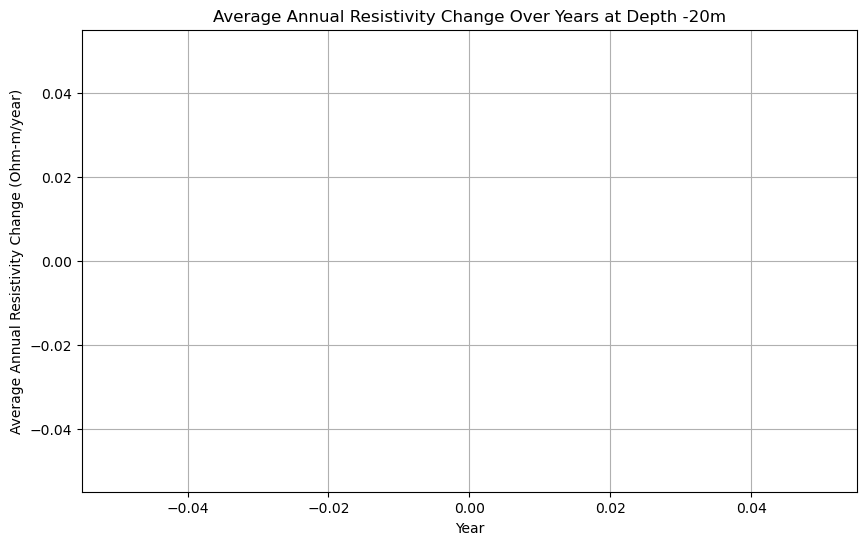

In [285]:
years = np.unique(east_shore[:, 2])

# Prepare a list to store the results
results = []

for year in years:
    # Select data for the current year
    data_year = east_shore[east_shore[:, 2] == year]
    
    if len(data_year) > 0:
        # Sort the data based on depth
        data_year = data_year[np.argsort(data_year[:, 1])]
        
        # Interpolate for depth -20m
        depths = data_year[:, 1]
        resistivities = data_year[:, 2]
        
        # Create interpolation function
        interp_func = interp1d(depths, resistivities, kind='linear', fill_value='extrapolate')
        
        # Interpolate at depth -20m
        resistivity_at_20m = interp_func(-20)
        
        # Store the result
        results.append({'Year': year, 'Resistivity_at_-20m': resistivity_at_20m})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Calculate average annual change in resistivity
change_list = []
years_between = []

for i in range(len(results_df) - 1):
    year1 = results_df.iloc[i]['Year']
    year2 = results_df.iloc[i + 1]['Year']
    resistivity1 = results_df.iloc[i]['Resistivity_at_-20m']
    resistivity2 = results_df.iloc[i + 1]['Resistivity_at_-20m']
    
    change = resistivity2 - resistivity1
    years_between.append(year2 - year1)
    change_list.append(change / (year2 - year1))

# Ensure lengths are consistent
if len(change_list) == len(results_df) - 1:
    # Create DataFrame for plotting
    change_df = pd.DataFrame({
        'Start_Year': results_df['Year'].iloc[:-1].values,
        'End_Year': results_df['Year'].iloc[1:].values,
        'Average_Annual_Change': change_list
    })
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(change_df['End_Year'], change_df['Average_Annual_Change'], marker='o', linestyle='-')
    plt.xlabel('Year')
    plt.ylabel('Average Annual Resistivity Change (Ohm-m/year)')
    plt.title('Average Annual Resistivity Change Over Years at Depth -20m')
    plt.grid(True)
    plt.show()

c:\Users\mealiy001\AppData\Local\anaconda3\envs\pgcore\Lib\site-packages\pygimli\viewer\mpl\utils.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.tight_layout()


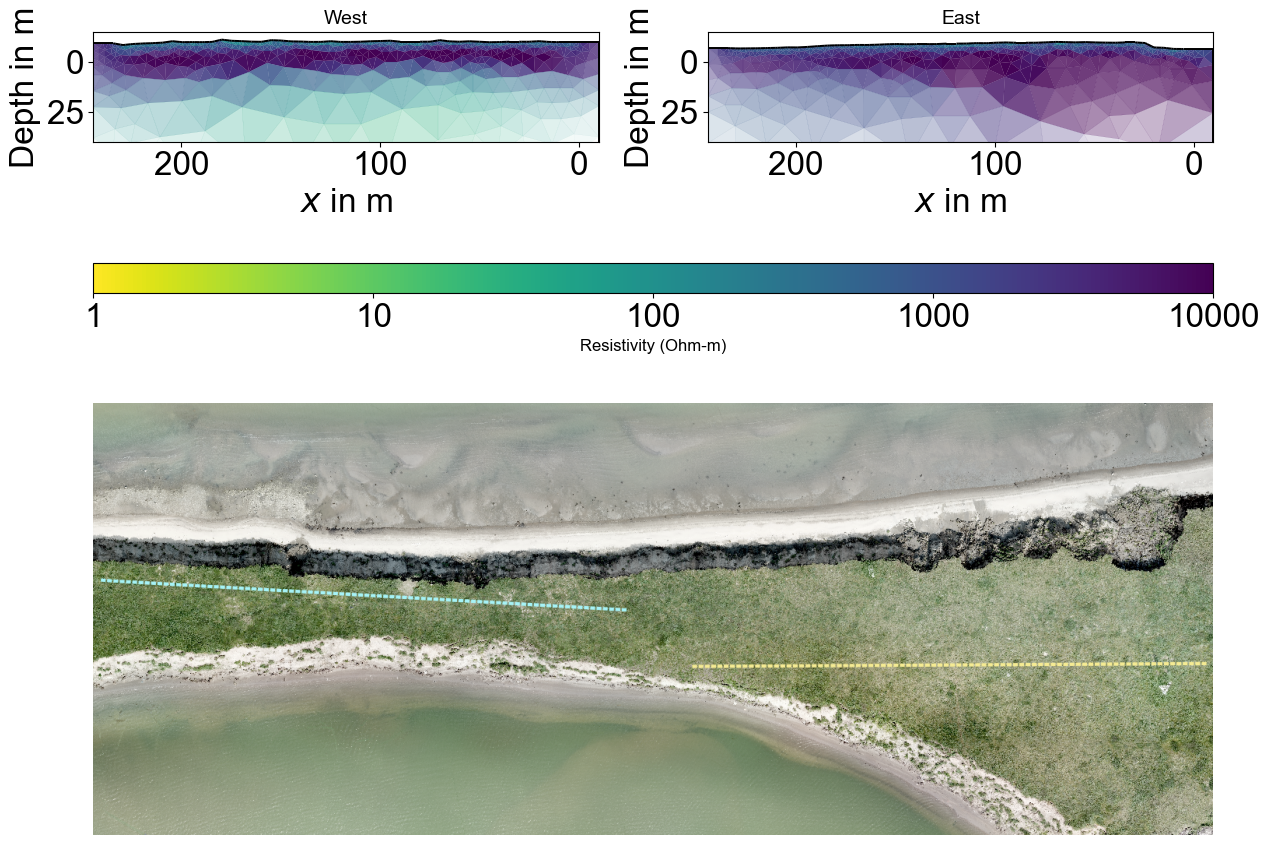

In [311]:
#img_eastern = mpimg.imread(dir+'paper/figures/eastgis1.png')
#img_western = mpimg.imread(dir+'paper/figures/westgis1.png')
img = mpimg.imread(dir+'paper/figures/bothgis.png')
cMin=1
cMax=10000

AL_e = np.loadtxt(dir + "pygimli/AL_eastern_parallel_to_shore.txt")
AL_w = np.loadtxt(dir + "pygimli/AL_western_parallel_to_shore.txt")

x_AL_e = AL_e[:, 0]
z_AL_e = AL_e[:, 1]
x_AL_w = AL_w[:, 0]
z_AL_w = AL_w[:, 1]

fig = plt.figure(figsize=(14, 20))
gs = gridspec.GridSpec(2, 2)

# Create the first subplot in the first row and first column
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, :])

cax = fig.add_axes([0.1, 0.53, 0.8, 0.015])  

colorbar = pg.viewer.mpl.createColorBarOnly(ax=cax, logScale=True, cMin=cMin, cMax=cMax,cMap="viridis_r")

pg.show(mesh_western_perpendicular, res_western_perpendicular, cMap="viridis_r", ax=ax0, cMin=cMin, cMax=cMax, colorBar=False, logScale=True, sharey = True, coverage=cov_western_perpendicular)
pg.show(mesh_eastern_perpendicular, res_eastern_perpendicular, cMap="viridis_r", ax=ax1, cMin=cMin, cMax=cMax, colorBar=False,logScale=True,  sharey = True, coverage=cov_eastern_perpendicular)

ax0.invert_xaxis()
ax1.invert_xaxis()

#ax[1][1].imshow(img_eastern)
#ax[1][1].axis('off')  


ax2.imshow(img)
ax2.axis('off')  

ax0.set_title('West', fontsize=14)
ax1.set_title('East', fontsize=14)

ax0.set_ylim(-40, 15)
ax1.set_ylim(-40, 15)
#ax0.plot(x_AL_w, z_AL_w, 'w--', linewidth=2)
#ax1.plot(x_AL_e, z_AL_e, 'w--', linewidth=2)


cax.set_xlabel('Resistivity (Ohm-m)', fontsize=12)
cax.xaxis.set_major_locator(LogLocator(base=10.0))
cax.xaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))
cax.set_xlabel('Resistivity (Ohm-m)', fontsize=12)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8) 

C:\Users\mealiy001\AppData\Local\Temp\ipykernel_24444\4103679847.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


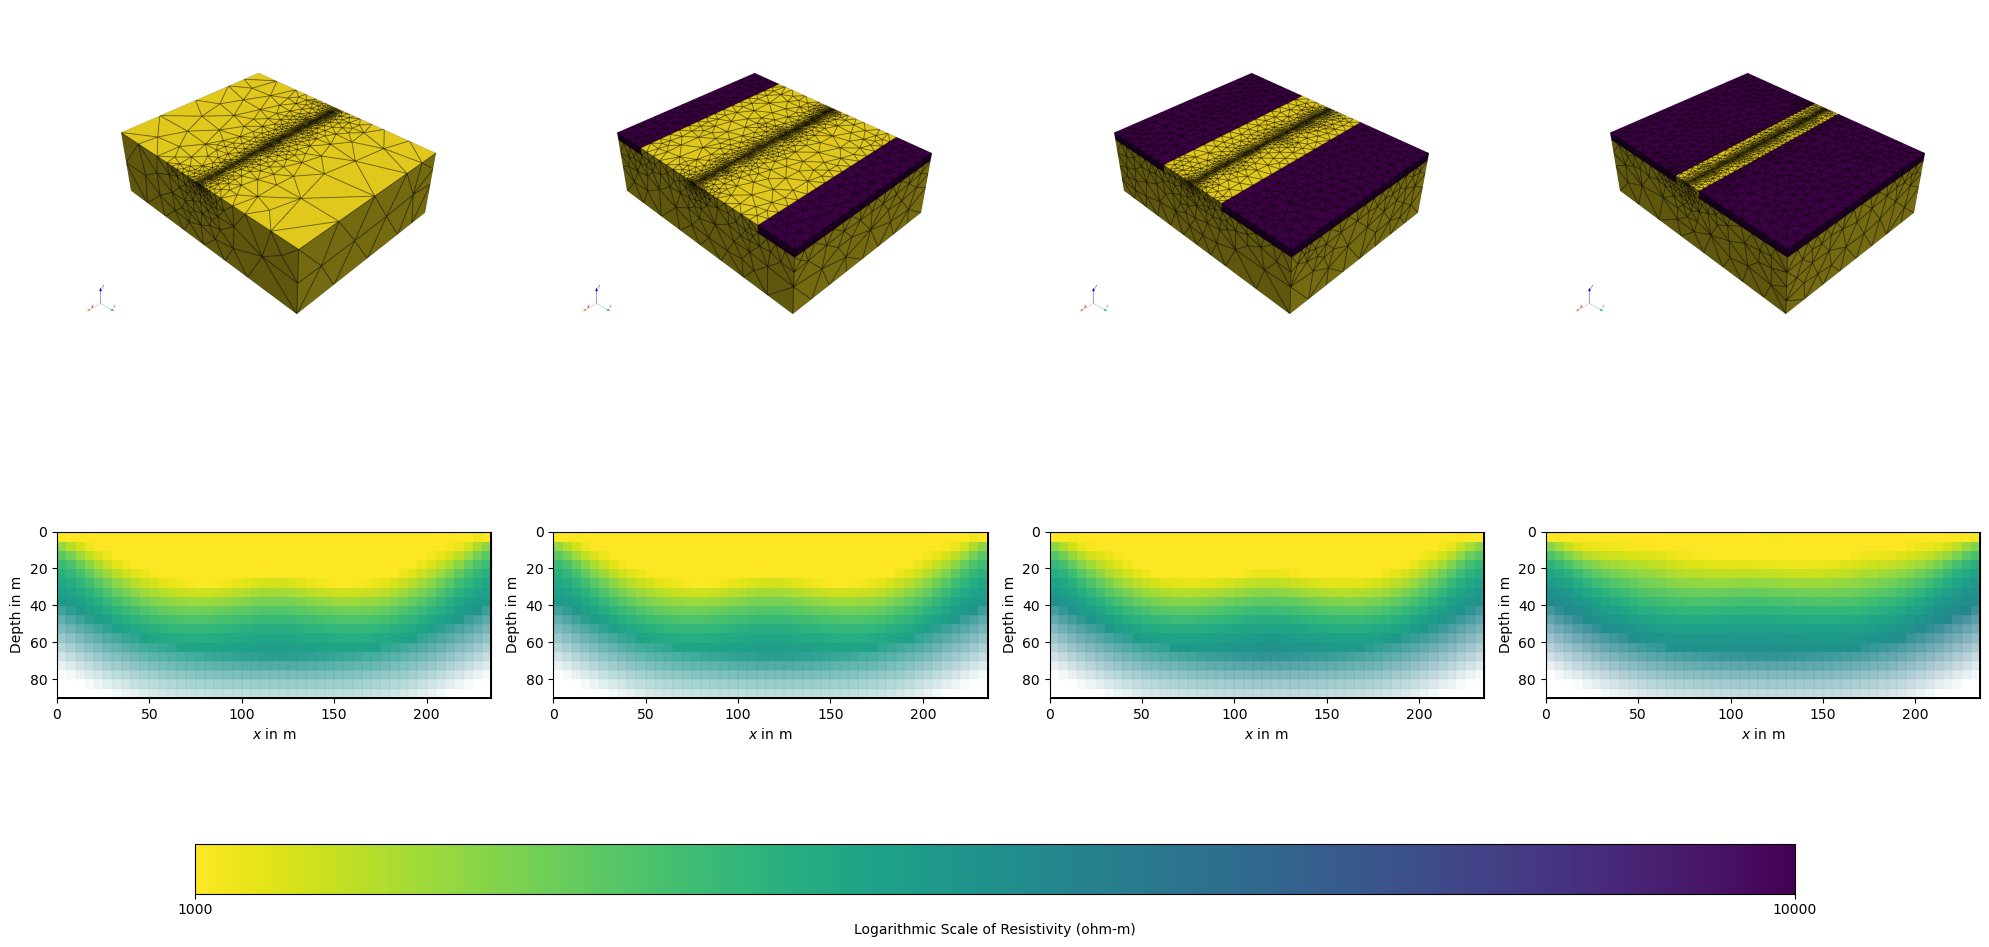

In [223]:
cMin = 1000
cMax= 10000

def render_vtk_to_image(filepath):
    # Load the VTK file
    mesh = pyvista.read(filepath)
    
    
    plotter = pyvista.Plotter(off_screen=True)
   
    plotter.add_mesh(mesh, cmap="viridis_r", show_scalar_bar=False, show_edges=True)  # Default color if no scalar data

    plotter.set_background("white")
    plotter.show_axes()  # Optional: Show axes for orientation

    # Render and capture the image
    img = plotter.screenshot(transparent_background=True)
    plotter.close()
    return img

vtk_files = [dir + '3dmod/mesh_hom.vtk', dir + '3dmod/mesh_air_thin.vtk', dir + '3dmod/mesh_air_mid.vtk', dir + '3dmod/mesh_air_wide.vtk']  # Replace with your actual VTK file paths


fig, ax = plt.subplots(2, 4, figsize=(20, 25))


for i, filepath in enumerate(vtk_files):
    img = render_vtk_to_image(filepath)
    ax[0, i].imshow(img)
    ax[0, i].axis('off') 

# Generate 2D plots in the right column
pg.show(mesh_hom, res_hom, logScale=True, cMap="viridis_r", ax=ax[1][0], cMin=cMin, cMax=cMax, colorBar=False, coverage=cov_hom, sharex=True)
pg.show(mesh_thin, res_thin, logScale=True, cMap="viridis_r", ax=ax[1][1], cMin=cMin, cMax=cMax, colorBar=False, coverage=cov_thin, sharex=True)
pg.show(mesh_mid, res_mid, logScale=True, cMap="viridis_r", ax=ax[1][2], cMin=cMin, cMax=cMax, colorBar=False, coverage=cov_mid, sharex=True)
pg.show(mesh_wide, res_wide, logScale=True, cMap="viridis_r", ax=ax[1][3], cMin=cMin, cMax=cMax, colorBar=False, coverage=cov_wide, sharex=True)




cax = fig.add_axes([0.1, 0.3, 0.8, 0.02])  

colorbar = pg.viewer.mpl.createColorBarOnly(ax=cax, cMin=cMin, cMax=cMax, logScale=True, cMap="viridis_r")

cax.xaxis.set_major_locator(LogLocator(base=10.0))
cax.xaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))
cax.set_xlabel('Logarithmic Scale of Resistivity (ohm-m)', fontsize=10)

#ax[0].set_title('Thin')
#ax[1].set_title('Mid')
#ax[2].set_title('Wide')



plt.tight_layout()
plt.show()

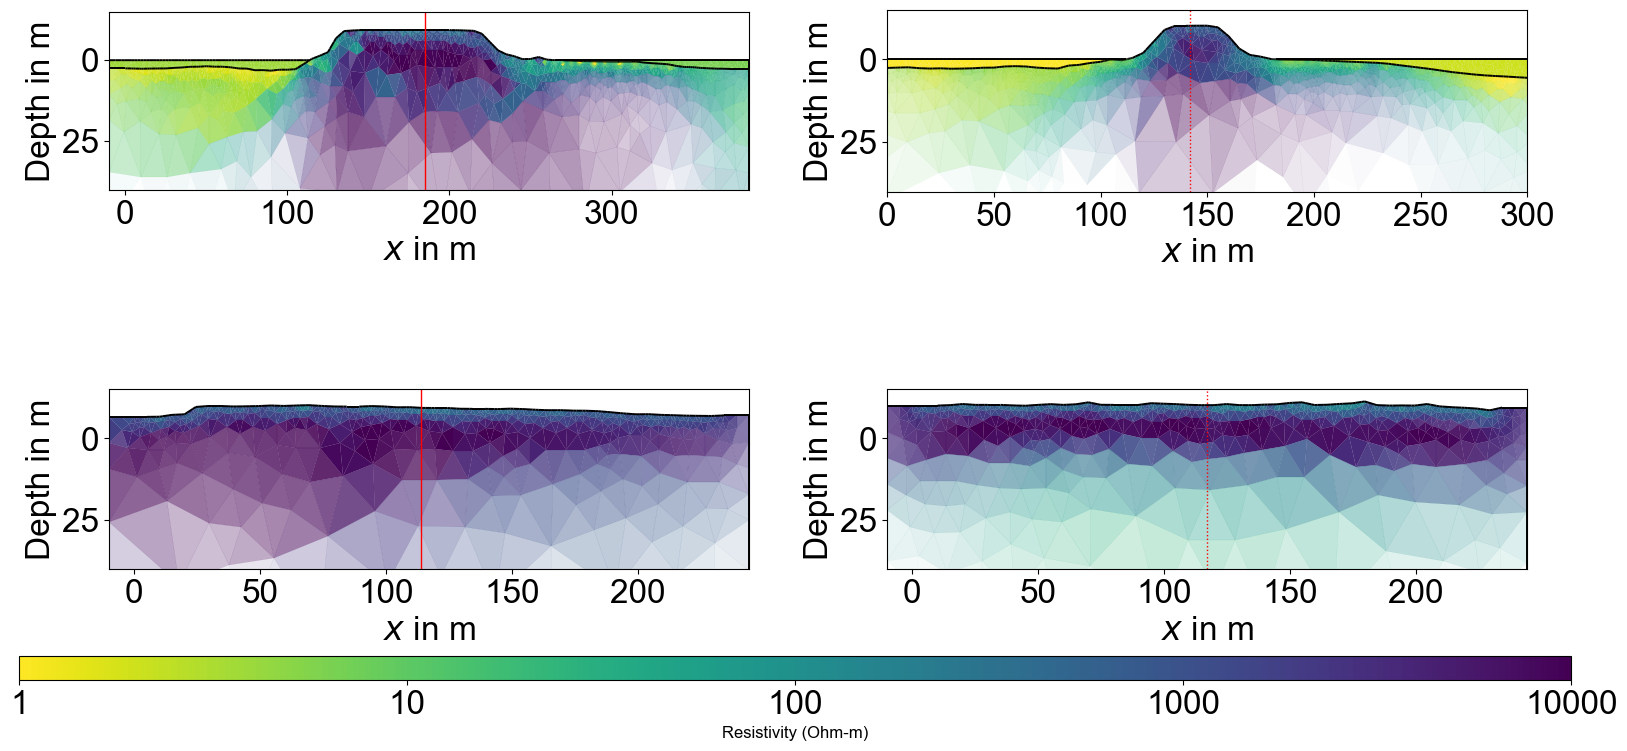

In [383]:
cMin=1
cMax=10000

fig, ax = plt.subplots(2, 2, figsize=(16, 8))

pg.show(mesh_eastern_newrhoa, res_eastern_newrhoa, cMap="viridis_r", ax=ax[0][0], cMin=cMin, cMax=cMax, colorBar=False, logScale=True, coverage=cov_eastern_newrhoa)
pg.show(mesh_western_newrhoa, res_western_newrhoa, cMap="viridis_r", ax=ax[0][1], cMin=cMin, cMax=cMax, colorBar=False, logScale=True, coverage=cov_western_newrhoa)
pg.show(mesh_eastern_perpendicular, res_eastern_perpendicular, cMap="viridis_r", ax=ax[1][0], cMin=cMin, cMax=cMax, colorBar=False, logScale=True, coverage=cov_eastern_perpendicular)
pg.show(mesh_western_perpendicular, res_western_perpendicular, cMap="viridis_r", ax=ax[1][1], cMin=cMin, cMax=cMax, colorBar=False, logScale=True, coverage=cov_western_perpendicular)

cax = fig.add_axes([0.03, 0.05, 0.97, 0.03])  

colorbar = pg.viewer.mpl.createColorBarOnly(ax=cax, logScale=True, cMin=cMin, cMax= cMax, cMap="viridis_r")

cax.xaxis.set_major_locator(LogLocator(base=10.0))
cax.xaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))
cax.set_xlabel('Resistivity (Ohm-m)', fontsize=12)

ax[0][0].set_ylim(-40, 15)
#ax0.set_ylabel("Depth (m)")
ax[0][1].set_ylim(-40, 15)
ax[0][1].set_xlim(0, 300)
ax[1][0].set_ylim(-40, 15)
ax[1][1].set_ylim(-40, 15)
ax[0][0].set_aspect(2)
ax[0][1].set_aspect(1.55)
ax[1][0].set_aspect(1.3)
ax[1][1].set_aspect(1.3)

ax[0][1].axvline(142, color='red', linewidth=1, linestyle=":")
ax[1][1].axvline(117, color='red', linewidth=1, linestyle=":")

ax[0][0].axvline(185, color='red', linewidth=1)
ax[1][0].axvline(114, color='red', linewidth=1)

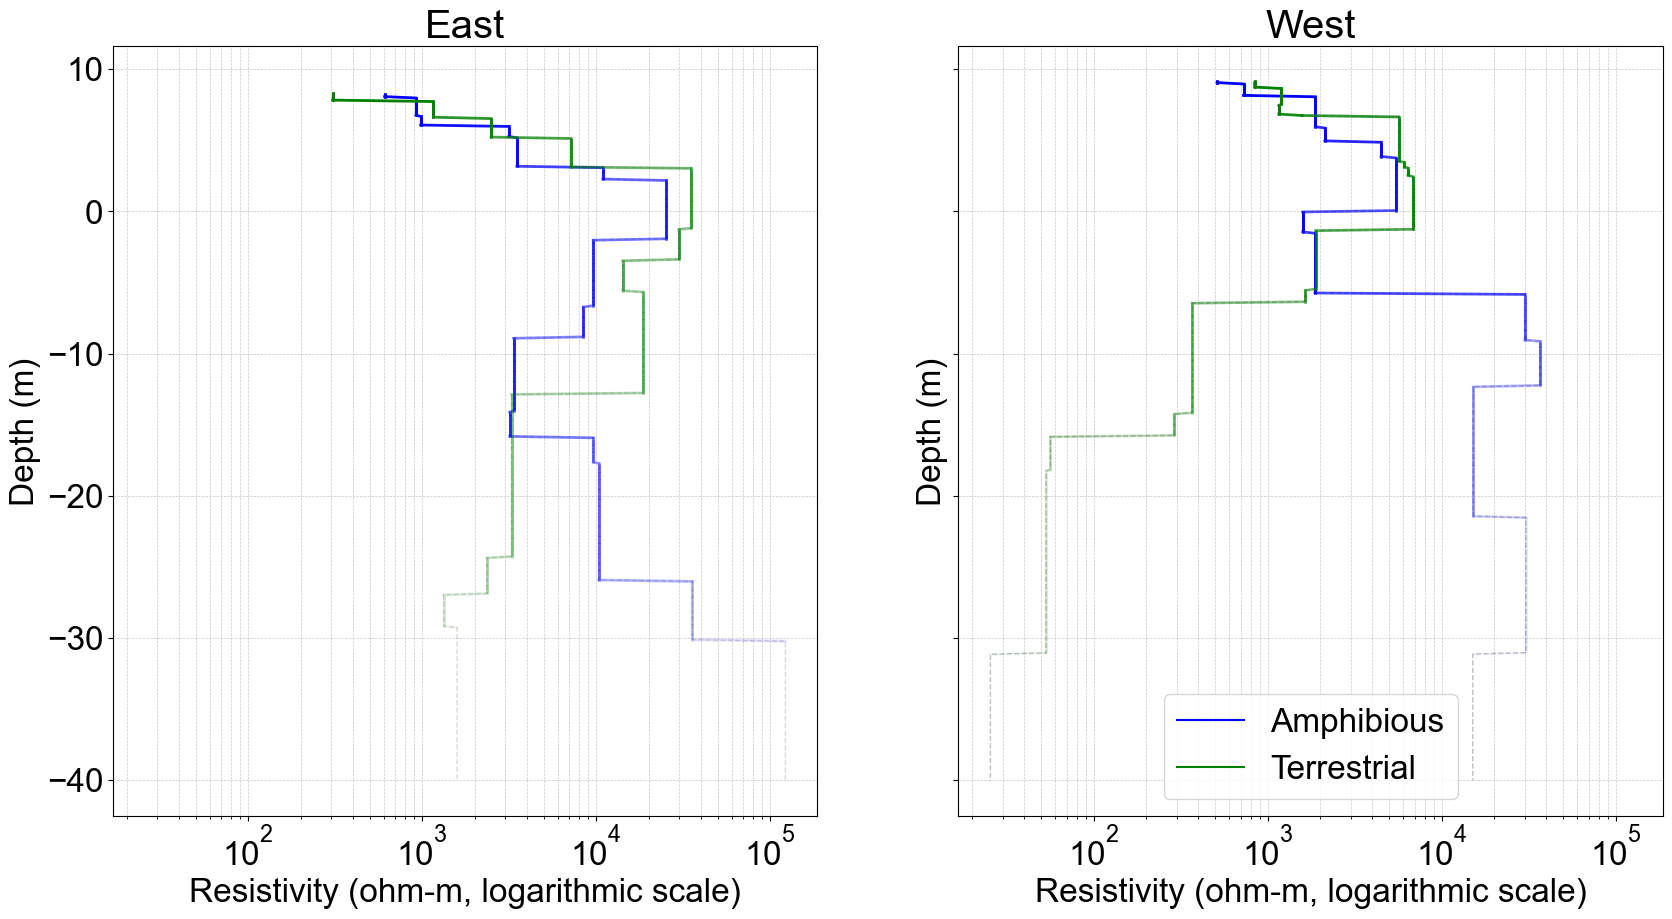

In [114]:
def get_cross_section(data, x, tolerance):
    result = data[data[:, 0] == data[np.isclose(data[:, 0], x, atol=tolerance)][0, 0]]
    #result = data[np.where(np.isclose(data[:, 0], x, atol=tolerance))[0][0]:] if np.any(np.isclose(data[:, 0], x, atol=tolerance)) else None
    return result

def normalize_coverage(coverage, dropThreshold=0.02):
    """
    Normalize coverage to determine alpha transparency values.
    """
    C = np.asarray(coverage)
    
    if (np.min(C) < 0.) or (np.max(C) > 1.) or (np.max(C) < 0.5):
        nn, hh = np.histogram(C, 50)
        nnn = nn.cumsum(axis=0) / float(len(C))
        
        mi = hh[np.min(np.where(nnn > 0.02)[0])]
        ma = hh[np.max(np.where(nnn < dropThreshold)[0])] if np.min(nnn) <= dropThreshold else np.max(C)
        
        C = (C - mi) / (ma - mi)
        C[C < 0.] = 0.0
        C[C > 0.95] = 1.0
    return C

# Load and normalize data for both eastern and western profiles
east_cross = get_cross_section(out_east, 185, 0.001)
east_coverage = normalize_coverage(east_cross[:, 3])
east_cross_p = get_cross_section(out_east_p, 114, 0.001)
east_p_coverage = normalize_coverage(east_cross_p[:, 3])

west_cross = get_cross_section(out_west, 142, 0.001)
west_coverage = normalize_coverage(west_cross[:, 3])
west_cross_p = get_cross_section(out_west_p, 117, 0.001)
west_p_coverage = normalize_coverage(west_cross_p[:, 3])



plt.rcParams['font.size'] = 24
plt.rcParams['font.family'] = 'Arial'
plt.style.use('seaborn-v0_8-colorblind')
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True, sharex=True)

# Scatter plots for Resistivity
# East plot
ax[0].plot(east_cross[:, 2], east_cross[:, 1], color="grey", linewidth=1, alpha=0.3, linestyle='dashed')
ax[0].plot(east_cross_p[:, 2], east_cross_p[:, 1], color="grey", linewidth=1, alpha=0.3, linestyle='dashed')

for i in range(1, len(east_cross)):
    ax[0].plot(east_cross[i-1:i+1, 2], east_cross[i-1:i+1, 1], alpha=east_coverage[i-1], color="blue", linewidth=2)
    
for i in range(1, len(east_cross_p)):
    ax[0].plot(east_cross_p[i-1:i+1, 2], east_cross_p[i-1:i+1, 1], alpha=east_p_coverage[i-1], color="green", linewidth=2)
    
# West plot
ax[1].plot(west_cross[:, 2], west_cross[:, 1], color="grey", linewidth=1, alpha=0.5, linestyle='dashed')
ax[1].plot(west_cross_p[:, 2], west_cross_p[:, 1], color="grey", linewidth=1, alpha=0.5, linestyle='dashed')

for i in range(1, len(west_cross)):
    ax[1].plot(west_cross[i-1:i+1, 2], west_cross[i-1:i+1, 1], alpha=west_coverage[i-1], color="blue", linewidth=2)
for i in range(1, len(west_cross_p)):
    ax[1].plot(west_cross_p[i-1:i+1, 2], west_cross_p[i-1:i+1, 1], alpha=west_p_coverage[i-1], color="green", linewidth=2)

# Add legends
amphibious_line = ax[0].plot([], [], color="blue", label="Amphibious")[0]
terrestrial_line = ax[0].plot([], [], color="green", label="Terrestrial")[0]

# Apply the same for the west subplot
ax[1].plot([], [], color="blue", label="Amphibious")
ax[1].plot([], [], color="green", label="Terrestrial")

east_x_min, east_x_max = east_cross[:, 2].min(), east_cross[:, 2].max()
west_x_min, west_x_max = west_cross[:, 2].min(), west_cross[:, 2].max()

global_x_min = min(east_x_min, west_x_min) * 0.01
global_x_max = max(east_x_max, west_x_max) * 10

# Apply the same x-axis limits to both subplots
#ax[0].set_xlim(global_x_min, global_x_max)
#ax[1].set_xlim(global_x_min, global_x_max)

# Labels and Title
ax[0].set_xlabel("Resistivity (ohm-m, logarithmic scale)")
ax[1].set_xlabel("Resistivity (ohm-m, logarithmic scale)")
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_ylabel("Depth (m)")
ax[1].set_ylabel("Depth (m)")
ax[0].set_title("East")
ax[1].set_title("West")
# Add grids to the plots
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Add legends
ax[1].legend(loc='best')


plt.savefig(dir+'paper/figures/virtual_borehole.png')




In [ ]:
east_coverage

C:\Users\mealiy001\AppData\Local\Temp\ipykernel_20296\3553644420.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])
C:\Users\mealiy001\AppData\Local\Temp\ipykernel_20296\3553644420.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])
C:\Users\mealiy001\AppData\Local\Temp\ipykernel_20296\3553644420.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


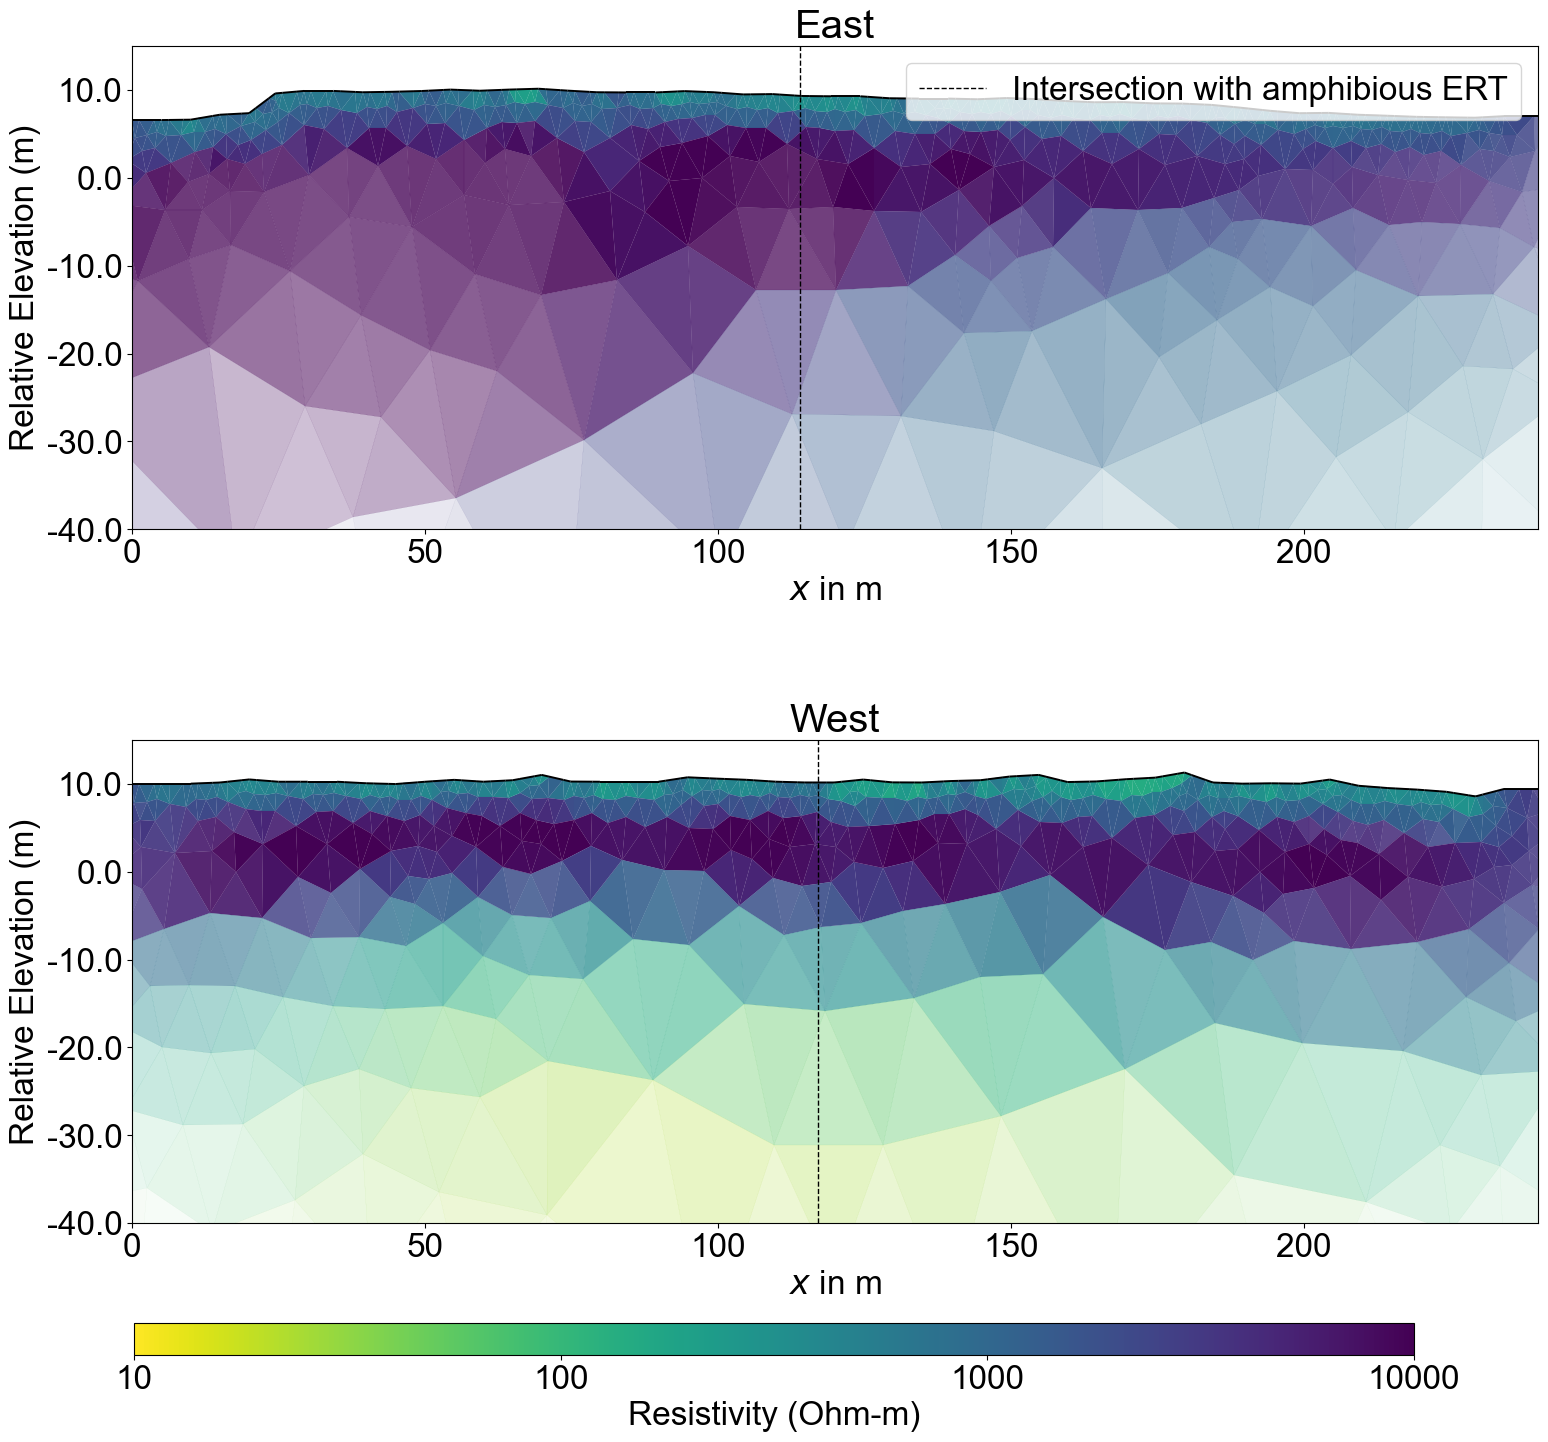

In [18]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 24

fig, ax = plt.subplots(2, 1, figsize=(16, 16), sharey=True)
ax0 = ax[0]
ax2 = ax[1]

pg.show(mesh_eastern_perpendicular, res_eastern_perpendicular,sharey=True, logScale=True, cMap="viridis_r", ax=ax0, cMin=cMin, cMax=cMax, colorBar=False, coverage=cov_eastern_perpendicular)
pg.show(mesh_western_perpendicular, res_western_perpendicular, sharey=True, logScale=True, cMap="viridis_r", ax=ax2, cMin=cMin, cMax=cMax, colorBar=False, coverage=cov_western_perpendicular)


ax0.set_ylim(-40, 15)
ax0.set_ylabel("Depth (m)")
ax2.set_ylim(-40, 15)
ax2.set_xlim(0, 240)
ax0.set_xlim(0, 240)

ax0.set_title('East')
ax2.set_title('West')
ax2.set_ylabel("Depth (m)")



ax0.set_aspect(1.5)
ax2.set_aspect(1.5)

ax2.axvline(117, color='black', linestyle="--", linewidth=1)
ax0.axvline(114, color='black', linestyle="--", linewidth=1, label="Intersection with amphibious ERT")


current_ticks = ax[0].get_yticks()
relative_ticks = current_ticks   # Assuming 17 is the minimum elevation

# Set the new tick labels to show relative elevation

ax0.set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])
ax0.set_ylabel("Relative Elevation (m)")
ax2.set_yticklabels([f"{tick:.1f}" for tick in relative_ticks])
ax2.set_ylabel("Relative Elevation (m)")


cax = fig.add_axes([0.1, 0.05, 0.8, 0.02])  

colorbar = pg.viewer.mpl.createColorBarOnly(ax=cax, logScale=True, cMin=cMin, cMax= cMax, cMap="viridis_r")

cax.xaxis.set_major_locator(LogLocator(base=10.0))
cax.xaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))
cax.set_xlabel('Resistivity (Ohm-m)')

ax0.legend(loc="upper right")
plt.tight_layout()
plt.savefig(dir+'paper/figures/terrestrial.png')


In [151]:
east_shoreline_plots = np.loadtxt(dir+'processing/shoreline/east_shoreline_plots.csv', delimiter=',', skiprows=1)
west_shoreline_plots = np.loadtxt(dir+'processing/shoreline/west_shoreline_plots.csv', delimiter=',', skiprows=1)

In [ ]:
east_shoreline_plots

In [90]:

with open(dir+'processing/shoreline/joined_east.pkl', 'rb') as f:
    joined_east = pickle.load(f)

eastshore = joined_east[['year', 'xc', 'zc']].to_numpy()

eastshore[:, 1] = eastshore[:, 1].round(decimals=0)  # Round 'xc'
eastshore[:, 2] = eastshore[:, 2].round(decimals=1)  # Round 'zc'

posVec = [pg.Pos(pos) for pos in zip(eastshore[:, 1], eastshore[:, 2])]

mesh_eastern_newrhoa.setCellMarkers(pg.IVector(mesh_eastern_newrhoa.cellCount()))

fopDP = PriorModelling(mesh_eastern_newrhoa, posVec)

resMesh_east = fopDP(res_eastern_newrhoa)
covMesh_east = fopDP(cov_eastern_newrhoa)
# Create a mesh and set cell markers
#np.savetxt(dir+"out.txt", np.column_stack((grid_points[:, 0], grid_points[:, 1], resMesh)))
east_shoreline_plots = np.column_stack((eastshore[:, 1], eastshore[:, 2], resMesh_east, eastshore[:, 0], covMesh_east))
east_shoreline_plots = np.c_[ east_shoreline_plots, 2023 - east_shoreline_plots[:, 3] ]



20/12/24 - 11:50:18 - pyGIMLi - INFO - Found 1 regions.


In [91]:
with open(dir+'processing/shoreline/joined_west.pkl', 'rb') as f:
    joined_west = pickle.load(f)

westshore = joined_west[['year', 'xc', 'zc']].to_numpy()

westshore[:, 1] = westshore[:, 1].round(decimals=0)  # Round 'xc'
westshore[:, 2] = westshore[:, 2].round(decimals=1)  # Round 'zc'

posVec = [pg.Pos(pos) for pos in zip(westshore[:, 1], westshore[:, 2])]

mesh_western_newrhoa.setCellMarkers(pg.IVector(mesh_western_newrhoa.cellCount()))

fopDP = PriorModelling(mesh_western_newrhoa, posVec)

resMesh_west = fopDP(res_western_newrhoa)
covMesh_west = fopDP(cov_western_newrhoa)
# Create a mesh and set cell markers
#np.savetxt(dir+"out.txt", np.column_stack((grid_points[:, 0], grid_points[:, 1], resMesh)))
west_shoreline_plots = np.column_stack((westshore[:, 1], westshore[:, 2], resMesh_west, westshore[:, 0], covMesh_west))
west_shoreline_plots = np.c_[ west_shoreline_plots, 2023 - west_shoreline_plots[:, 3] ]

20/12/24 - 11:50:20 - pyGIMLi - INFO - Found 1 regions.


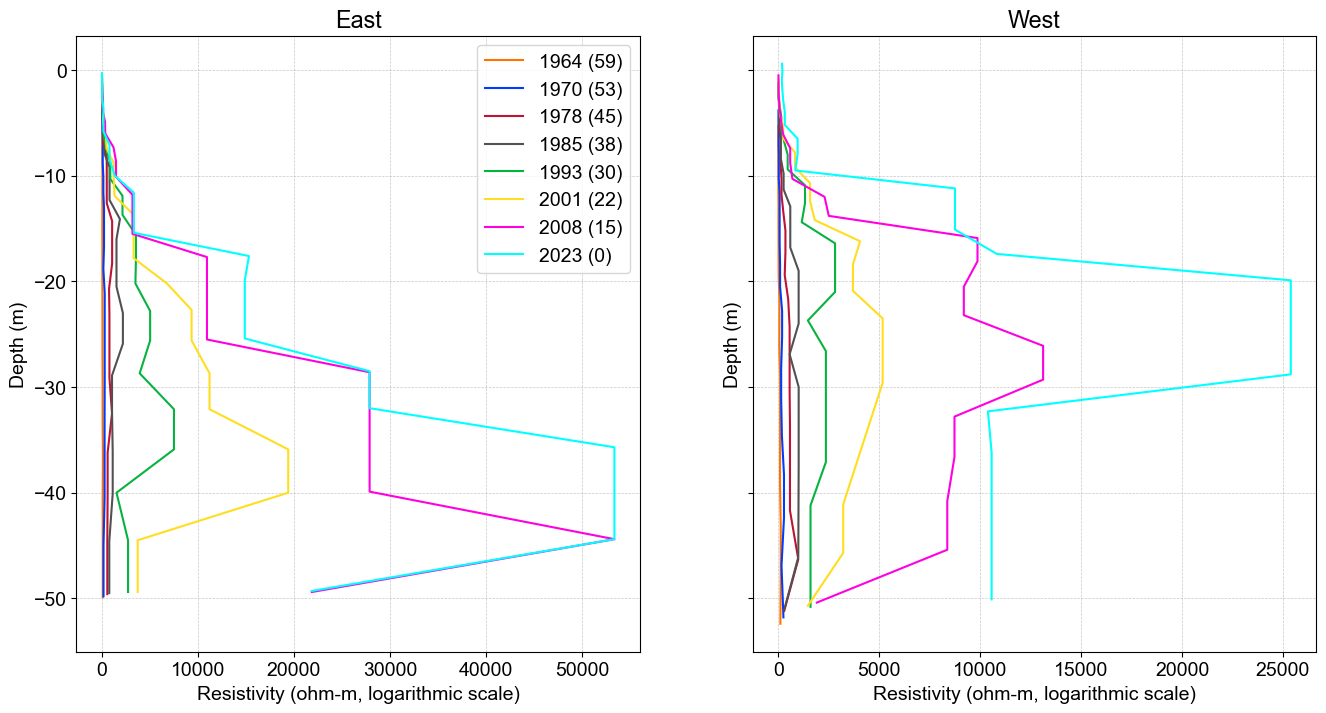

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

years = np.unique(west_shoreline_plots[:, 3])
years_east = np.unique(east_shoreline_plots[:, 3])
years_west = np.unique(west_shoreline_plots[:, 3])
east_coverage_all = normalize_coverage(east_shoreline_plots[:, 4])
west_coverage_all = normalize_coverage(west_shoreline_plots[:, 4])


plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Arial'
colors = ['#ff7300', '#003cff', '#be1332', '#515151', '#07b340', '#ffdd1f', '#ff00e1', 'aqua']  # Blue to green to yellow to red
#colors = colors[::-1]
cmap_name = 'custom_cmap'

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
custom_cmap= custom_cmap.reversed()
# Plotting each year's resistivity values with depth


# Define the years and their corresponding colors
year_color_map = {
    year: colors[i % len(colors)]
    for i, year in enumerate(years)
}

fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharey=True)


for year in years_east:
   
    data_year_east = east_shoreline_plots[east_shoreline_plots[:, 3] == year]
    data_year_east = data_year_east[np.argsort(data_year_east[:, 1])]  # Sort by depth
    ax[0].plot(data_year_east[:, 2], data_year_east[:, 1], label=f"{int(year)} ({int(2023 - year)})", color=year_color_map[year])
    

for year in years_west:
   
    data_year_west = west_shoreline_plots[west_shoreline_plots[:, 3] == year]
    data_year_west = data_year_west[np.argsort(data_year_west[:, 1])]  # Sort by depth
    ax[1].plot(data_year_west[:, 2], data_year_west[:, 1], color=year_color_map[year])

ax[0].set_xlabel("Resistivity (ohm-m, logarithmic scale)")
ax[1].set_xlabel("Resistivity (ohm-m, logarithmic scale)")
#ax[0].set_xscale('log')
#ax[1].set_xscale('log')
ax[0].set_ylabel("Depth (m)")
ax[1].set_ylabel("Depth (m)")
ax[0].set_title("East")
ax[1].set_title("West")
# Add grids to the plots
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

#ax[0].set_xlim(1, 100000)
#ax[1].set_xlim(1, 100000)

# Add legends
ax[0].legend(loc='best')

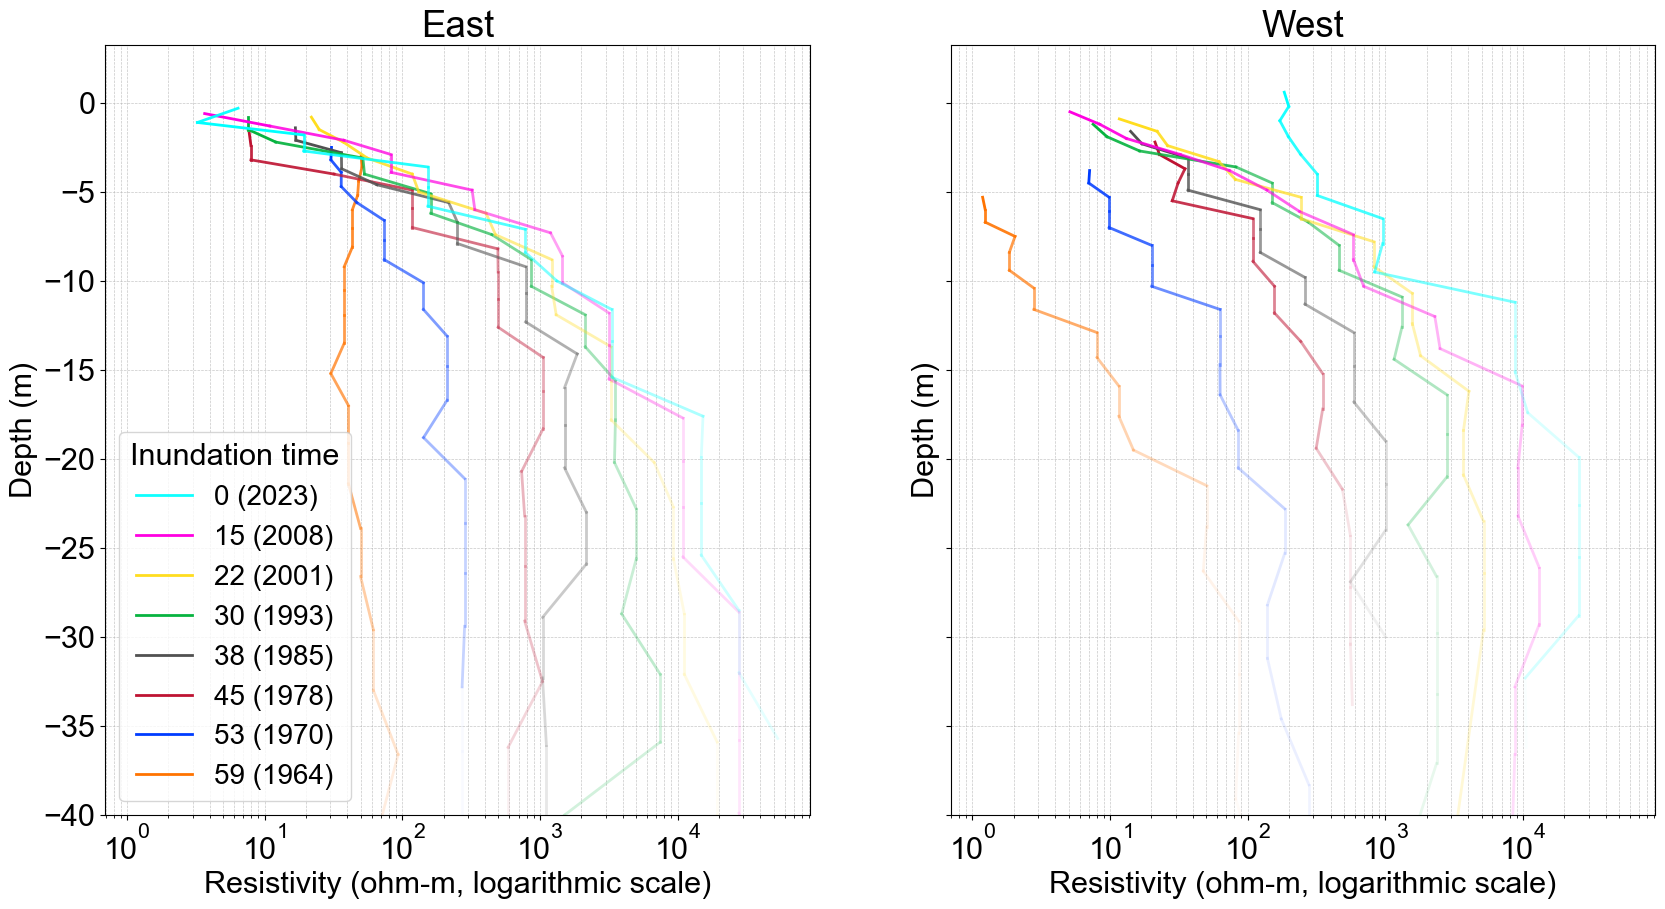

In [140]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Assuming normalize_coverage function is available



# Load data (assuming your data loading is correct, so no need to modify that)
years = np.unique(west_shoreline_plots[:, 3])
years_east = np.unique(east_shoreline_plots[:, 3])
years_west = np.unique(west_shoreline_plots[:, 3])

# Set plot style and parameters
plt.rcParams['font.size'] = 22
plt.rcParams['font.family'] = 'Arial'

# Define colors for the years
colors = ['#ff7300', '#003cff', '#be1332', '#515151', '#07b340', '#ffdd1f', '#ff00e1', 'aqua']
cmap_name = 'custom_cmap'

# Create a custom colormap
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
#custom_cmap = custom_cmap.reversed()

# Map years to colors
year_color_map = {
    year: colors[i % len(colors)]
    for i, year in enumerate(years)
}

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True, sharex=True)


# Track years added to the legend
east_legend_added = set()
west_legend_added = set()

# Plot east shoreline profiles
for year in years_east:
    data_year_east = east_shoreline_plots[east_shoreline_plots[:, 3] == year]
    #data_year_east = data_year_east[np.argsort(data_year_east[:, 1])]  # Sort by depth
    
    # Normalize the coverage for the entire year
    coverage_for_year = normalize_coverage(data_year_east[:, 4])  # Coverage data for this year
    
    # Plot each segment with the corresponding alpha for the segment
    for i in range(1, len(data_year_east)):
        label = f"{int(2023 - year)} ({int(year)})" if year not in east_legend_added else None
        ax[0].plot(data_year_east[i-1:i+1, 2], data_year_east[i-1:i+1, 1], 
                   alpha=coverage_for_year[i-1], color=year_color_map[year], linewidth=2, linestyle="solid", label=label)
        east_legend_added.add(year)
# Plot west shoreline profiles
for year in years_west:
    data_year_west = west_shoreline_plots[west_shoreline_plots[:, 3] == year]
    #data_year_west = data_year_west[np.argsort(data_year_west[:, 1])]  # Sort by depth
    
    # Normalize the coverage for each profile segment
    coverage_for_year = normalize_coverage(data_year_west[:, 4])  # Coverage data for this year
    
    # Plot each line segment with corresponding alpha (from coverage)
    for i in range(1, len(data_year_west)):
        ax[1].plot(data_year_west[i-1:i+1, 2], data_year_west[i-1:i+1, 1], 
                   alpha=coverage_for_year[i-1], color=year_color_map[year], linewidth=2, linestyle="-")



# Set plot labels and titles
ax[0].set_xlabel("Resistivity (ohm-m, logarithmic scale)")
ax[1].set_xlabel("Resistivity (ohm-m, logarithmic scale)")
ax[0].set_ylabel("Depth (m)")
ax[1].set_ylabel("Depth (m)")
ax[0].set_title("East")
ax[1].set_title("West")
ax[0].set_ylim(-40)
ax[1].set_ylim(-40)
ax[0].set_xscale('log')
ax[1].set_xscale('log')
# Add grids to the plots
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

handles_east, labels_east = ax[0].get_legend_handles_labels()

ax[0].legend(handles_east[::-1], labels_east[::-1], loc='best', title="Inundation time", fontsize=20)
# Add legends


# Save the plot
plt.savefig(dir+'paper/figures/shoreline_plot_with_alpha.png')



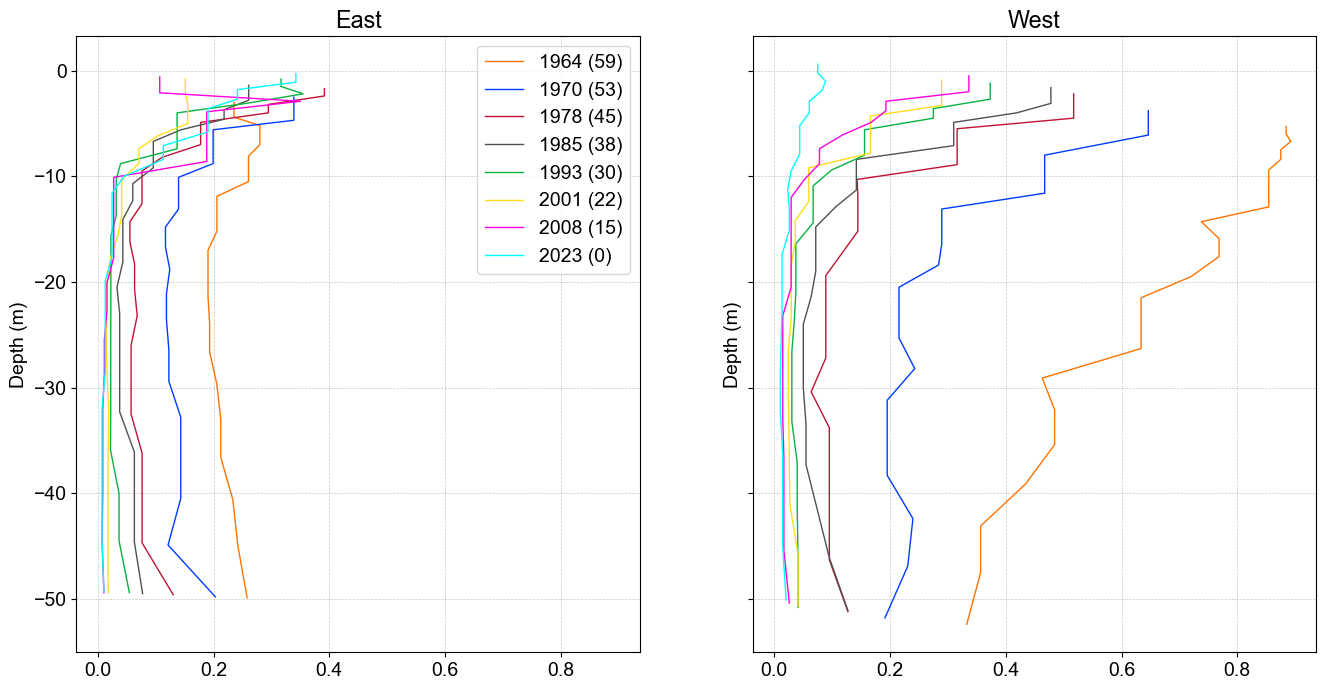

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Assuming data is loaded (west_shoreline_plots, east_shoreline_plots) and normalize_coverage is defined elsewhere

# Normalize the coverage for both east and west shorelines
years = np.unique(west_shoreline_plots[:, 3])
years_east = np.unique(east_shoreline_plots[:, 3])
years_west = np.unique(west_shoreline_plots[:, 3])
east_coverage_all = normalize_coverage(east_shoreline_plots[:, 4])
west_coverage_all = normalize_coverage(west_shoreline_plots[:, 4])

plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Arial'
colors = ['#ff7300', '#003cff', '#be1332', '#515151', '#07b340', '#ffdd1f', '#ff00e1', 'aqua']
cmap_name = 'custom_cmap'

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
custom_cmap = custom_cmap.reversed()

# Define the years and their corresponding colors
year_color_map = {year: colors[i % len(colors)] for i, year in enumerate(years)}

# Create the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharey=True, sharex=True)

# Plotting east shoreline profiles
for year in years_east:
    data_year_east = east_shoreline_plots[east_shoreline_plots[:, 3] == year]
    data_year_east = data_year_east[np.argsort(data_year_east[:, 1])]  # Sort by depth
    
    # Plot line segments without dots (no markers)
    ax[0].plot(data_year_east[:, 5], data_year_east[:, 1], label=f"{int(year)} ({int(2023 - year)})", 
               color=year_color_map[year], linewidth=1)

# Plotting west shoreline profiles
for year in years_west:
    data_year_west = west_shoreline_plots[west_shoreline_plots[:, 3] == year]
    data_year_west = data_year_west[np.argsort(data_year_west[:, 1])]  # Sort by depth
    
    # Plot line segments without dots (no markers)
    ax[1].plot(data_year_west[:, 5], data_year_west[:, 1], color=year_color_map[year], linewidth=1)

# Set axis labels and titles
#ax[0].set_xlabel("Resistivity (ohm-m, logarithmic scale)")
#ax[1].set_xlabel("Resistivity (ohm-m, logarithmic scale)")
ax[0].set_ylabel("Depth (m)")
ax[1].set_ylabel("Depth (m)")
ax[0].set_title("East")
ax[1].set_title("West")

# Add grids to the plots
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Add legends
ax[0].legend(loc='best')




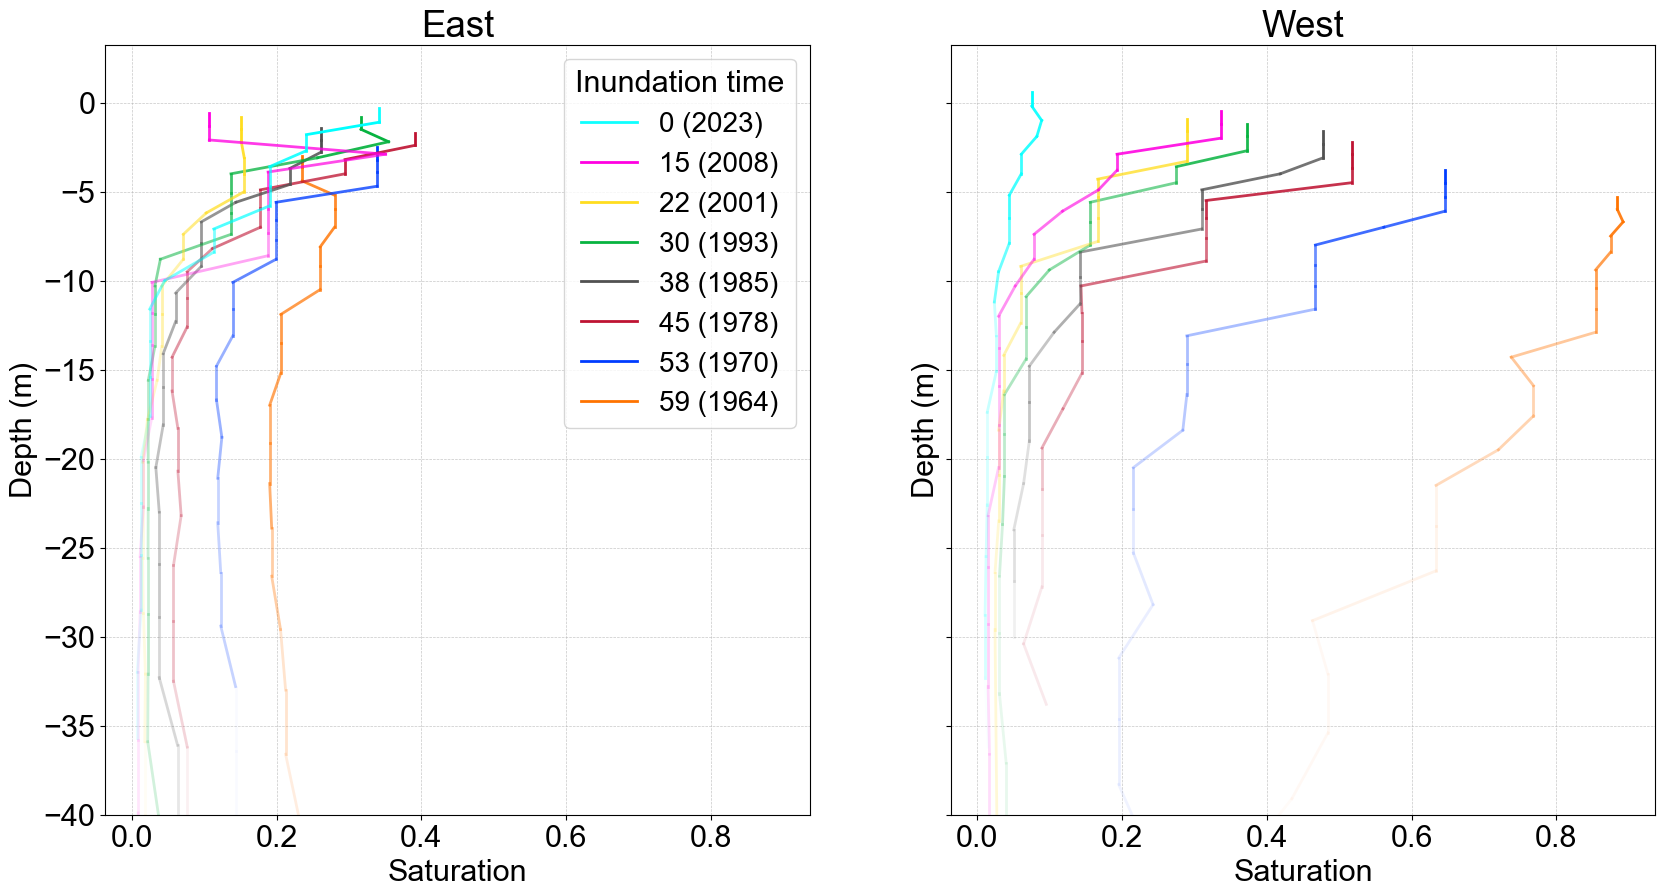

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Assuming normalize_coverage function is available



# Load data (assuming your data loading is correct, so no need to modify that)
years = np.unique(west_shoreline_plots[:, 3])
years_east = np.unique(east_shoreline_plots[:, 3])
years_west = np.unique(west_shoreline_plots[:, 3])

# Set plot style and parameters
plt.rcParams['font.size'] = 22
plt.rcParams['font.family'] = 'Arial'

# Define colors for the years
colors = ['#ff7300', '#003cff', '#be1332', '#515151', '#07b340', '#ffdd1f', '#ff00e1', 'aqua']
cmap_name = 'custom_cmap'

# Create a custom colormap
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
#custom_cmap = custom_cmap.reversed()

# Map years to colors
year_color_map = {
    year: colors[i % len(colors)]
    for i, year in enumerate(years)
}

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True, sharex=True)


# Track years added to the legend
east_legend_added = set()
west_legend_added = set()

# Plot east shoreline profiles
for year in years_east:
    data_year_east = east_shoreline_plots[east_shoreline_plots[:, 3] == year]
    #data_year_east = data_year_east[np.argsort(data_year_east[:, 1])]  # Sort by depth
    
    # Normalize the coverage for the entire year
    coverage_for_year = normalize_coverage(data_year_east[:, 4])  # Coverage data for this year
    
    # Plot each segment with the corresponding alpha for the segment
    for i in range(1, len(data_year_east)):
        label = f"{int(2023 - year)} ({int(year)})" if year not in east_legend_added else None
        ax[0].plot(data_year_east[i-1:i+1, 5], data_year_east[i-1:i+1, 1], 
                   alpha=coverage_for_year[i-1], color=year_color_map[year], linewidth=2, linestyle="solid", label=label)
        east_legend_added.add(year)
# Plot west shoreline profiles
for year in years_west:
    data_year_west = west_shoreline_plots[west_shoreline_plots[:, 3] == year]
    #data_year_west = data_year_west[np.argsort(data_year_west[:, 1])]  # Sort by depth
    
    # Normalize the coverage for each profile segment
    coverage_for_year = normalize_coverage(data_year_west[:, 4])  # Coverage data for this year
    
    # Plot each line segment with corresponding alpha (from coverage)
    for i in range(1, len(data_year_west)):
        ax[1].plot(data_year_west[i-1:i+1, 5], data_year_west[i-1:i+1, 1], 
                   alpha=coverage_for_year[i-1], color=year_color_map[year], linewidth=2, linestyle="-")



# Set plot labels and titles
ax[0].set_xlabel("Saturation")
ax[1].set_xlabel("Saturation")
ax[0].set_ylabel("Depth (m)")
ax[1].set_ylabel("Depth (m)")
ax[0].set_title("East")
ax[1].set_title("West")
ax[0].set_ylim(-40)
ax[1].set_ylim(-40)
#ax[0].set_xscale('log')
#ax[1].set_xscale('log')
# Add grids to the plots
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

handles_east, labels_east = ax[0].get_legend_handles_labels()

ax[0].legend(handles_east[::-1], labels_east[::-1], loc='best', title="Inundation time", fontsize=20)